In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, BSpline
import numpy as np
from scipy import stats
import random
import math
from footprint_filter import filter_by_footprint
from voidiness import voidy_analysis
import pickle
import matplotlib.patches as mpatches
from custom_functions import z_mask, get_sim_idx

In [2]:
sdss_dr16 = pd.read_excel('exported_dataFrames/sdss_dr16_w_voidiness.xlsx')
four_lac = pd.read_excel('exported_dataFrames/4lac_w_voidiness.xlsx')

In [3]:
hard_xrays = pd.read_excel('exported_dataFrames/SBAT104_w_voidiness.xlsx')
soft_xrays = pd.read_excel('exported_dataFrames/ROMABZCAT_w_voidiness.xlsx')

In [4]:
print(len(sdss_dr16))
sdss_dr16 = sdss_dr16.drop_duplicates(subset=['RAdeg', 'DEdeg'], keep='first')
print(len(sdss_dr16))

92730
83753


In [5]:
print(len(four_lac))
four_lac = four_lac.drop_duplicates(subset=['RAdeg', 'DEdeg'], keep='first')
print(len(four_lac))

328
328


In [6]:
print(len(soft_xrays))
soft_xrays = soft_xrays.drop_duplicates(subset=['RAdeg', 'DEdeg'], keep='first')
print(len(soft_xrays))

445
445


In [7]:
print(len(hard_xrays))
hard_xrays = hard_xrays.drop_duplicates(subset=['RAdeg', 'DEdeg'], keep='first')
print(len(hard_xrays))

184
184


In [8]:
# Read in variables
with open('stats/simulated_data/nontev_only_w_voidiness_simulated_data.pkl', 'rb') as f:
    mc_nontev = pickle.load(f)

with open('stats/simulated_data/ROMABZCAT_w_voidiness_simulated_data.pkl', 'rb') as f:
    mc_soft_xrays = pickle.load(f)

with open('stats/simulated_data/SBAT104_w_voidiness_simulated_data.pkl', 'rb') as f:
    mc_hard_xrays = pickle.load(f)

with open('stats/simulated_data/4lac_w_voidiness_simulated_data.pkl', 'rb') as f:
    mc_four_lac = pickle.load(f)

with open('stats/simulated_data/TeV_list_simulated_data.pkl','rb') as f:
    mc_tev = pickle.load(f)
    
with open('stats/simulated_data/qsos_w_voidiness_simulated_data.pkl', 'rb') as f:
    mc_sdss_qso = pickle.load(f)

In [152]:
catalogs = ["Four_LAC","TEV_Sources", "NON_TEV_Sources", "SDSS_DR16_QSR","SDSS_DR16_GLX", "ROMABZCAT", "SBAT105"]
stat_nums = ["Statistic", "pvalue"]
statistics = pd.DataFrame(np.nan, columns=catalogs, index  =catalogs)
is_qsr = sdss_dr16.AUTOCLASS_PQN == "QSO"
is_glx = sdss_dr16.AUTOCLASS_PQN == "GALAXY"
is_tev = four_lac.TeVflag == 1
is_not_tev = np.isnan(four_lac.TeVflag)
# zbin = [0.4 , 0.7]
# zbin = [0.1, 0.4]
zbin    = [0.1, 0.7]
unbinned_df = [four_lac[is_tev]
               ,four_lac[is_not_tev]
               ,soft_xrays
               ,hard_xrays
               ,four_lac
               ,sdss_dr16[is_qsr]
]
data = [four_lac.Voidiness[z_mask(four_lac, zbin)]
        # ,four_lac[is_tev].Voidiness[z_mask(four_lac[is_tev], zbin)]          # TeV
        # ,four_lac[is_not_tev].Voidiness[z_mask(four_lac[is_not_tev], zbin)] # Non-TeV
        ,soft_xrays.Voidiness[z_mask(soft_xrays, zbin)]                     # Soft Xrays
        ,hard_xrays.Voidiness[z_mask(hard_xrays, zbin)]                     # Hard X-Rays
        # ,sdss_dr16[is_glx].Voidiness[z_mask(sdss_dr16[is_glx], zbin)]       # SDSS GlX
        ,sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)]       # SDSS QSO
        ,mc_four_lac[get_sim_idx(mc_four_lac, unbinned_df[4], zbin)]
        # ,mc_tev[get_sim_idx(mc_tev,unbinned_df[0],zbin)]                    # mc_tev
        # ,mc_nontev[get_sim_idx(mc_nontev,unbinned_df[1],zbin)]              # mc_nontev
        ,mc_soft_xrays[get_sim_idx(mc_soft_xrays,unbinned_df[2],zbin)]      # mc_soft_xrays
        ,mc_hard_xrays[get_sim_idx(mc_hard_xrays,unbinned_df[3],zbin)]      # mc_hard_xrays
        ,mc_sdss_qso[get_sim_idx(mc_sdss_qso,unbinned_df[5], zbin)]
        ]

Z_BINNED_DATA = data
other_data = [four_lac.Voidiness[is_tev]
              ,four_lac.Voidiness[is_not_tev]
              ,soft_xrays.Voidiness
              ,hard_xrays.Voidiness]
big_mc_data = [mc_tev, mc_nontev, mc_soft_xrays, mc_hard_xrays]

In [153]:
catalogs = ["4LAC"
            # ,"VHE"
            # ,"GeV"
            , "Soft X-Rays"
            , "Hard X-Rays"
            # , "SDSS DR16 (GLX)"
            , "SDSS DR16 (QSO)"
            ,"Simulated 4LAC"
            # ,"Simulated VHE"
            # , "Simulated GeV"
            , "Simulated Soft X-Rays"
            , "Simulated Hard X-Rays"
            , "Simulated SDSS DR16 (QSO)"] 



In [154]:
len(catalogs)

8

In [155]:
len(data)

8

In [156]:
# # TODO: TEST IF THIS LOOP IS DOING THE COMPARISONS WE THINK ITS DOING
# ks_table = {}
# p_vals = {}
# statistics = {}
# for i in range(len(other_data)):
#     temp = {}
#     tempks = {}
#     tempie ={}
#     for j in range(i, len(big_mc_data)):
#         stt =  stats.ks_2samp(other_data[i], big_mc_data[j])
#         temp[catalogs[j]] = (stt[0], stt[1])
#         tempks[catalogs[j]] = stt[0]
#         tempie[catalogs[j]] = stt[1]
#         # print(catalogs[i], catalogs[j], stats.ks_2samp(data[i], data[j]))
#     statistics[catalogs[i]] = temp
#     ks_table[catalogs[i]] = tempks
#     p_vals[catalogs[i]] = tempie



In [157]:
# TODO: TEST IF THIS LOOP IS DOING THE COMPARISONS WE THINK ITS DOING
ks_table = {}
p_vals = {}
statistics = {}
alphas = {}
for i in range(len(data)):
    temp = {}
    tempks = {}
    tempie ={}
    tempa = {}
    for j in range(i, len(data)):
        n = len(data[i])
        m = len(data[j])
        stt =  stats.ks_2samp(data[i], data[j])
        tempks[catalogs[j]] = stt[0]
        tempie[catalogs[j]] = stt[1]
        ks = stt[0]
        a =  2 * np.exp(-2 * (ks**2) *((n * m)/(n+m))) 
        tempa[catalogs[j]] = a
        temp[catalogs[j]] = (stt[0], stt[1], a)
        # print(catalogs[i], catalogs[j], stats.ks_2samp(data[i], data[j]))
    statistics[catalogs[i]] = temp
    ks_table[catalogs[i]] = tempks
    p_vals[catalogs[i]] = tempie
    alphas[catalogs[i]] = tempa

In [158]:
stats_table = pd.DataFrame(statistics)

In [159]:
zbin = [0.4, 0.7]
stats.ks_2samp(four_lac.Voidiness[z_mask(four_lac, zbin)], sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)])

KstestResult(statistic=0.23177315834850082, pvalue=3.4390210688404725e-07, statistic_location=0.3082272205975325, statistic_sign=-1)

In [160]:
stats_table

,4LAC,Soft X-Rays,Hard X-Rays,SDSS DR16 (QSO),Simulated 4LAC,Simulated Soft X-Rays,Simulated Hard X-Rays,Simulated SDSS DR16 (QSO)
4LAC,"(0.0, 1.0, 2.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Soft X-Rays,"(0.09229303212011342, 0.09047964899690279, 0.0...","(0.0, 1.0, 2.0)",NaN,NaN,NaN,NaN,NaN,NaN
Hard X-Rays,"(0.1515951595159516, 0.2953029136015841, 0.330...","(0.10015649452269171, 0.768803473811833, 0.883...","(0.0, 1.0, 2.0)",NaN,NaN,NaN,NaN,NaN
SDSS DR16 (QSO),"(0.12526850376293774, 0.00015545562212417952, ...","(0.062024077701657965, 0.07748133763663911, 0....","(0.11043041421250122, 0.6034916100830181, 0.66...","(0.0, 1.0, 2.0)",NaN,NaN,NaN,NaN
Simulated 4LAC,"(0.033313531353135306, 0.8795579594709739, 1.0...","(0.069989866592293, 0.029607467487975492, 0.03...","(0.12308030803080305, 0.4663229920590568, 0.51...","(0.10344591684625404, 2.993813190027044e-163, ...","(0.0, 1.0, 2.0)",NaN,NaN,NaN
Simulated Soft X-Rays,"(0.03788420954771535, 0.7624637935658003, 0.83...","(0.06672769953051638, 0.04337532504477748, 0.0...","(0.12239593114240999, 0.47336397973076183, 0.5...","(0.10238808232922425, 2.0058265899713258e-165,...","(0.005651187653976653, 0.006975966100407639, 0...","(0.0, 1.0, 2.0)",NaN,NaN
Simulated Hard X-Rays,"(0.094528492849285, 0.008913344548802604, 0.00...","(0.03554679186228482, 0.6529143736937346, 0.69...","(0.09342222222222218, 0.7927962002151521, 0.91...","(0.05326773890492184, 2.2249736182495917e-26, ...","(0.06824378437843781, 8.918953893067619e-80, 1...","(0.06765821596244137, 1.9342286382490125e-81, ...","(0.0, 1.0, 2.0)",NaN
Simulated SDSS DR16 (QSO),"(0.05610548540892002, 0.28516619782234853, 0.2...","(0.08894746298322229, 0.0022086366409742675, 0...","(0.1387333756515787, 0.32155322399889197, 0.35...","(0.0843010790463723, 2.5909417776725124e-122, ...","(0.03127144970781698, 3.667947859199437e-127, ...","(0.036435660395222225, 7.914217637312683e-241,...","(0.09191354724597889, 1.7521311715276846e-165,...","(0.0, 1.0, 2.0)"


In [161]:
kssies = pd.DataFrame(ks_table)
kssies.to_excel("exported_dataFrames/KS_table.xlsx")
p_vals = pd.DataFrame(p_vals)
p_vals.to_excel("exported_dataFrames/P_vals.xlsx")
alphas = pd.DataFrame(alphas)

In [162]:
kssies

,4LAC,Soft X-Rays,Hard X-Rays,SDSS DR16 (QSO),Simulated 4LAC,Simulated Soft X-Rays,Simulated Hard X-Rays,Simulated SDSS DR16 (QSO)
4LAC,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Soft X-Rays,0.092293,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hard X-Rays,0.151595,0.100156,0.000000,NaN,NaN,NaN,NaN,NaN
SDSS DR16 (QSO),0.125269,0.062024,0.110430,0.000000,NaN,NaN,NaN,NaN
Simulated 4LAC,0.033314,0.069990,0.123080,0.103446,0.000000,NaN,NaN,NaN
Simulated Soft X-Rays,0.037884,0.066728,0.122396,0.102388,0.005651,0.000000,NaN,NaN
Simulated Hard X-Rays,0.094528,0.035547,0.093422,0.053268,0.068244,0.067658,0.000000,NaN
Simulated SDSS DR16 (QSO),0.056105,0.088947,0.138733,0.084301,0.031271,0.036436,0.091914,0.0


In [163]:
p_vals

,4LAC,Soft X-Rays,Hard X-Rays,SDSS DR16 (QSO),Simulated 4LAC,Simulated Soft X-Rays,Simulated Hard X-Rays,Simulated SDSS DR16 (QSO)
4LAC,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Soft X-Rays,0.090480,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hard X-Rays,0.295303,0.768803,1.000000,NaN,NaN,NaN,NaN,NaN
SDSS DR16 (QSO),0.000155,0.077481,0.603492,1.000000e+00,NaN,NaN,NaN,NaN
Simulated 4LAC,0.879558,0.029607,0.466323,2.993813e-163,1.000000e+00,NaN,NaN,NaN
Simulated Soft X-Rays,0.762464,0.043375,0.473364,2.005827e-165,6.975966e-03,1.000000e+00,NaN,NaN
Simulated Hard X-Rays,0.008913,0.652914,0.792796,2.224974e-26,8.918954e-80,1.934229e-81,1.000000e+00,NaN
Simulated SDSS DR16 (QSO),0.285166,0.002209,0.321553,2.590942e-122,3.667948e-127,7.914218e-241,1.752131e-165,1.0


In [469]:
alphas

,4LAC,Soft X-Rays,Hard X-Rays,SDSS DR16 (GLX),SDSS DR16 (QSO),Simulated 4LAC,Simulated Soft X-Rays,Simulated Hard X-Rays
4LAC,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Soft X-Rays,2.516415e-02,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hard X-Rays,4.697499e-01,0.358552,2.000000,NaN,NaN,NaN,NaN,NaN
SDSS DR16 (GLX),1.167894e-14,0.000004,0.091205,2.000000e+00,NaN,NaN,NaN,NaN
SDSS DR16 (QSO),4.856274e-07,0.123538,0.215568,1.681151e-105,2.000000e+00,NaN,NaN,NaN
Simulated 4LAC,3.487644e-02,0.444815,0.454426,0.000000e+00,1.837139e-152,2.000000,NaN,NaN
Simulated Soft X-Rays,2.278783e-02,0.580485,0.438599,0.000000e+00,7.567433e-141,0.008322,2.000000,NaN
Simulated Hard X-Rays,8.512974e-02,0.379464,0.471228,9.798198e-70,3.701719e-20,0.718783,0.426396,2.0


In [39]:
# Taken from custom_functions.py and modified for our purposes, 
# Since I've making new scripts for everything custom_functions is kind of depecrated
# and I didn't want to break it. 

def rand_long_and_lat(n, seeded=False, seed = 567307250717):
    """
    Generates number of longitude and latitude coordinates in degrees for entire pandasDF
    """
    if seeded:
        seed = seed # Using seed while debugging
    else:
        seed = None

    rng = np.random.default_rng(seed) 
    theta = np.arccos(1 - 2 * rng.uniform(0, 1, n)) * (180/math.pi) # COLAT
    b = 90 - theta
    l = rng.uniform(0, 360, n)
    return (l, b)
# Randomize

def gen_filtered_ra_deg(n):
    randRA, randDE = rand_long_and_lat(n)
    temp_cel = pd.DataFrame({'RAdeg': randRA, 'DEdeg': randDE})
    temp_cel = filter_by_footprint(temp_cel, 'exported_dataFrames/footprint_points_void_centers.xlsx')
    return temp_cel

In [40]:
# # Monte Carlo of TEV
# voids = pd.read_excel('exported_dataFrames/voids.xlsx')
# master_TEV_Carlo = four_lac[four_lac.TeVflag == 1].copy()

# run_n = 0
# mc_voidiness = np.array([])
# n_galxy = len(master_TEV_Carlo)


In [41]:
# # First monte carlo run. Depecrated after run_monte_carlo has been written
# while True:
#     coords = gen_filtered_ra_deg(100000)
#     coords_idx = coords.index.tolist()
#     while len(coords_idx) > n_galxy:
#         fresh_coords_idx = coords_idx[:n_galxy]
#         coords_idx = coords_idx[n_galxy:]

#         master_TEV_Carlo['RAdeg'] = coords.RAdeg[fresh_coords_idx].values
#         master_TEV_Carlo['DEdeg'] = coords.DEdeg[fresh_coords_idx].values
#         mc_voidiness = np.append(mc_voidiness, voidy_analysis(voids, master_TEV_Carlo).Voidiness.values) # This one takes about 6s per run
#         run_n += 1
#     # print(run_n)

In [42]:
def ret_sim_bin_heights(mc_vals, n_galxy, binning, cflag, show=True):
    """Returns the bin heights and plots them"""
    sim_bin_heights = []
    for i in range(int(len(mc_vals)/n_galxy)):
        temp = plt.hist([mc_vals[i*n_galxy:n_galxy*(i+1)]], 
                            bins = binning, 
                            density=True, 
                            stacked = False,
                            histtype='step',
                            cumulative=cflag, alpha=0.01, color='0.5')
        sim_bin_heights.append(temp[0])
    if show:
        # plt.show()
        pass
    else:
        plt.clf()  
    return sim_bin_heights

In [119]:
start = 0
end = 1
num = 10
binning = np.linspace(start,end,num)

sigma_vals = [34.1, 34.1+13.6]
observed_data = four_lac.Voidiness[four_lac.TeVflag == 1]
observed_label = "Observed TeV"
len_data = len(observed_data)
mc_data = mc_tev
plot_median = True
median_c = 'g'
cflag = False # cumulative
show_sim_overlay = False
fill_btwn_c = 'b'
fill_alpha = 0.1
plot_sdss = False
sdss_color = "k"

# Plot parameters
title = '4LAC Non-TeV Sources'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'Simulated 4LAC Non-TeV'

# jp
def plot_everything(num = 10
                    ,binning = np.linspace(start,end,num)
                    ,sigma_vals = [34.1, 34.1+13.6]
                    ,observed_data = four_lac.Voidiness[four_lac.TeVflag == 1]
                    ,observed_label = "Observed TeV"
                    ,observed_color = "magenta"
                    ,len_data = len(observed_data)
                    ,mc_data = mc_tev
                    ,plot_median = False
                    ,median_c = 'g'
                    ,cflag = False # cumulative
                    ,show_sim_overlay = False
                    ,fill_btwn_c = 'b'
                    ,fill_alpha = 0.1
                    ,title = '4LAC Non-TeV Sources'
                    ,xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
                    ,ylabel = 'Normalized Fraction'
                    ,appended_label = 'Simulated 4LAC Non-TeV'
                    ,plot_sdss_qsr = False
                    ,sdss_qsr_color = 'k'
                    ,sdss_glx_color = 'orange'
                    ,plot_sdss_glx = False
                    ,save = True
                    ,all_sim_c='cyan'
                    ,add_stats = False
                    ,plot_c_sim = False
                    ,legend_override = None
                    ,zbin = [0.1, 0.7]
                    ,qso_override = None
                    ,deal_w_montecarlo = True
                    ,sdss_num = 100
                    ,sdss_fill_alpha = 0.2
                    ,plot_sdss_only = False):
    global is_qsr, is_glx
    sim_bin_heights = ret_sim_bin_heights(mc_data, len_data, binning, cflag, show = show_sim_overlay)
    BIN_IT = mc_sdss_qso[get_sim_idx(mc_sdss_qso, sdss_dr16[is_qsr], zbin)]
    LEN = len(sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)])
    sdss_sim_bin_heights = ret_sim_bin_heights(BIN_IT, LEN, np.linspace(0,1,sdss_num), cflag, show = show_sim_overlay)
    plt.figure()

    if ~plot_sdss_only:
        plt.hist(observed_data, 
                            bins = binning, 
                            density=True, 
                            stacked = False,
                            histtype='step'
                            , label=observed_label + f"n = {len(observed_data):,}"
                            ,cumulative=cflag, color = observed_color)

    if plot_sdss_qsr:
        plt.hist([sdss_dr16.Voidiness[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)]]
                , bins = np.linspace(0, 1, sdss_num)
                , density=True
                , stacked = False
                , histtype='step'
                , label="SDSS DR16 (QSR) Observed"
                , cumulative=cflag, 
                color=sdss_qsr_color)        
    if plot_sdss_glx:
        plt.hist([sdss_dr16.Voidiness[is_glx][z_mask(sdss_dr16[is_glx], zbin)]]
                , bins = binning
                , density=True
                , stacked = False
                , histtype='step'
                , label="SDSS DR16 (GLX) Observed"
                , cumulative=cflag, color=sdss_glx_color)
    if ~plot_sdss_only:
        if deal_w_montecarlo:
            if plot_c_sim:
                plt.hist(mc_data
                        , bins = binning
                        , density=True
                        , stacked = False
                        , histtype='step'
                        , label="All Simulated"
                        , cumulative=cflag, color=all_sim_c)
            org = []
            for i in range(num-1):
                org.append([[heights[i] for heights in sim_bin_heights]])

            medians = []
            for i in range(num-1):
                medians.append(np.median(org[i]))
            
            ks, p = stats.ks_2samp(observed_data, mc_data)
            # ks_obv, p_obv = stats.ks_2samp(observed_data)
            # Plot the sigma bands
            lab = ['1 $\sigma$', '2 $\sigma$']
            ii = 0
            for s, l in zip(sigma_vals, lab):
                hi_sig = []
                low_sig = []
                for i in range(num-1):
                    # Calculate the upper 1 sigma
                    hi_sig.append(np.percentile(org[i], [50 + s])[0])
                    # Lower
                    low_sig.append(np.percentile(org[i], [50 - s])[0])
                if ii %2 == 0:
                    l = None
                plt.fill_between(binning[:-1], hi_sig, low_sig
                                , step="post"
                                , alpha = fill_alpha
                                , color = fill_btwn_c
                                , label=l
                                #  , edgecolor = 'orange'
                                )
                ii += 1
    # Do it again but for qso   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # plt.hist(BIN_IT
    #     , bins = binning
    #     , density=True
    #     , stacked = False
    #     , histtype='step'
    #     , label="All Simulated"
    #     , cumulative=cflag, color='magenta')
    org = []
    for i in range(sdss_num-1):
        org.append([[heights[i] for heights in sdss_sim_bin_heights]])

    medians = []
    for i in range(sdss_num-1):
        medians.append(np.median(org[i]))
    
    # ks, p = stats.ks_2samp(observed_data, mc_data)
    # ks_obv, p_obv = stats.ks_2samp(observed_data)
    # Plot the sigma bands
    lab = ['1 $\sigma$', '2 $\sigma$']
    ii = 0
    for s, l in zip(sigma_vals, lab):
        hi_sig = []
        low_sig = []
        for i in range(sdss_num-1):
            # Calculate the upper 1 sigma
            hi_sig.append(np.percentile(org[i], [50 + s])[0])
            # Lower
            low_sig.append(np.percentile(org[i], [50 - s])[0])
        if ii %2 == 0:
            l = None
        plt.fill_between(np.linspace(0,1,sdss_num)[:-1], hi_sig, low_sig
                        , step="post"
                        , alpha = sdss_fill_alpha
                        , color = 'k'
                        , label=l
                        #  , edgecolor = 'orange'
                        )
        ii += 1
    # TODO: Save the calculated sigma values. They are discarded after plotting
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # CONVENTION
    # Median happens at left of bin, y value held towards the right of point until 
    # start of next bin. Hence, i exclude the leftmost bin edge

    if plot_median:
        plt.step(binning[:-1], medians, where="post", label="Median of Sim. Data", color = median_c) 

    # Add the grey patches to the legend
    if show_sim_overlay:
        grey_patch = mpatches.Patch(color='grey', alpha = 0.5, label='Simulated 4LAC Non-TeV')
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.append(grey_patch)
        labels.append(appended_label)
        plt.legend(handles=handles, labels=labels)
    
    # Commenting out the legend
    # else:
    #     plt.legend()
    # if legend_override:
    #     # plt.legend(legend_override)
    #     plt.legend(legend_override,loc='upper center', bbox_to_anchor=(0.5, -0.01),
    #       fancybox=True, shadow=True, ncol=3)
    if cflag:
        plt.ylabel("Empirical Cumulative Distribution Function")
    else:
        plt.ylabel(ylabel)
    
    plt.xlabel(xlabel)
    if add_stats:
        title = title+ f"\nKS: {ks:.2}\np: {p:.2e}"
    plt.title(title)
    plt.grid()

    if cflag:
        wm_x, wm_y = (0.7, 0.15)
    else:
        wm_x, wm_y = (0.27, 0.85)
    # plt.text(wm_x, wm_y, "Preliminary",  # Adjust the position as needed
    #                 fontsize=30, color='gray', alpha=0.5,
    #                 ha='center', va='center', transform=plt.gca().transAxes)
    if cflag:
        fn = title+"CDF.png"
    else:
        fn = title+"NormalHistogram.png"
    
    if save:
        plt.savefig("stats/stats_fig/"+fn)

def get_median_of_sim_data(sim_bin_heights, num):
    org = []
    for i in range(num-1):
        org.append([[heights[i] for heights in sim_bin_heights]])

    medians = []
    for i in range(num-1):
        medians.append(np.median(org[i]))
    return medians


In [44]:
def plot_in_cdf(array_of_dfs, cdfbins
                , zbins
                # , title=None
                , labels
                , cflag=True
                # , xlabel = "Voidiness"
                ,add_legend=False):
    for i in range(len(zbins)-1):
        plt.figure() 
        for j in range(len(array_of_dfs)):
             df = array_of_dfs[j]
             mask = (df.z < zbins[i+1]) & (df.z >= zbins[i])
 
             plt.hist(df.Voidiness[mask]
                    , bins = cdfbins
                    , density=True
                    , stacked = False
                    , histtype='step'
                    , label=labels[j]
                    , cumulative=cflag
                    )
        if add_legend:
            plt.legend()
        plt.grid()
        plt.title(f"z:{zbins[i]:.2f} - {zbins[i+1]:.2f} ")

        plt.ylabel("Emperical Cumulative Distribution Function")
        plt.xlabel("Voidiness")

In [45]:
# Get indices of simulated voidiness values that fall within specific redshift
def get_sim_idx(sim, real_df, zbin):
    mask = (real_df.z < zbin[1]) & (real_df.z>=zbin[0])
    idx_mask  = [i for i, val in enumerate(mask) if val]
    len_dat = len(real_df)
    l_sim = len(sim)
    n_samples = l_sim/len_dat

    assert n_samples%1 == 0, "Length of simulated datapoints is not integer multiple of length of data"

    n_samples = int(n_samples)
    # for i in range(n_samples):
    #     for idx in idx_mask:
    #         idx + len_dat*i
    return [idx + len_dat*i for i in range(n_samples) for idx in idx_mask]

    

<Figure size 640x480 with 0 Axes>

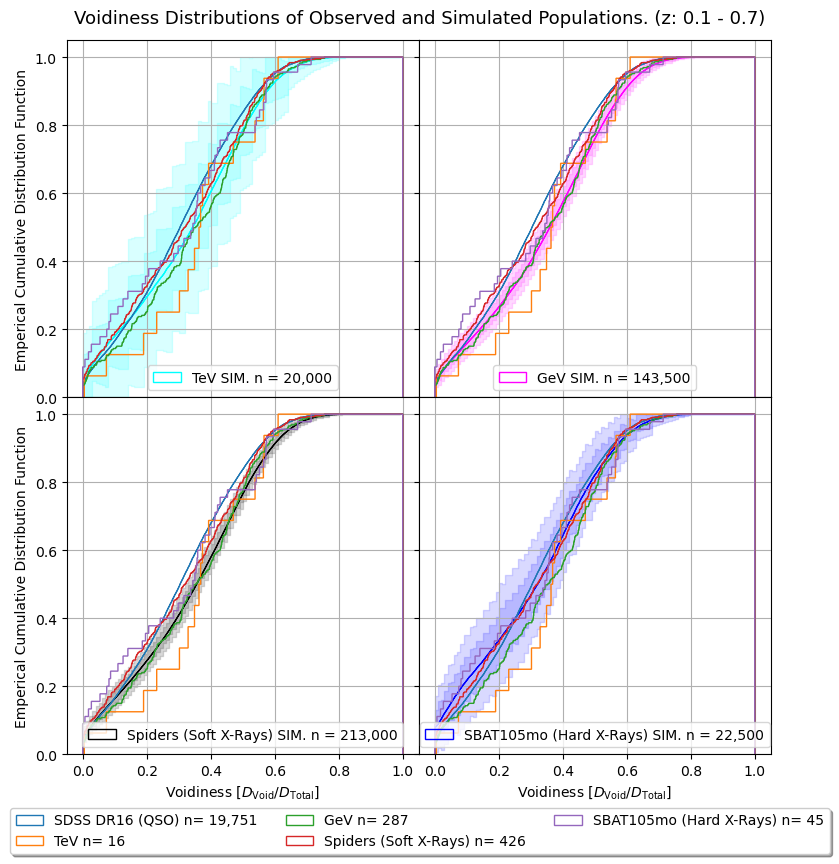

In [46]:
cdfbins = np.linspace(0,1,1000)
# cdfbins = 10
cflag = True
zbin = [0.1, 0.7]

sims = [mc_tev
        ,mc_nontev
        ,mc_soft_xrays
        ,mc_hard_xrays]
sim_labels = ["TeV SIM."
              ,"GeV SIM."
              ,"Spiders (Soft X-Rays) SIM."
              ,"SBAT105mo (Hard X-Rays) SIM."]

obs_data = [sdss_dr16[is_qsr]
                    # , sdss_dr16[is_glx]
                    , four_lac[is_tev]
                    , four_lac[~is_tev]
                    , soft_xrays
                    , hard_xrays]
obs_labels = ["SDSS DR16 (QSO)"
            #   ,"SDSS DR16 (GLX)"
              ,"TeV"
              ,"GeV"
              ,"Spiders (Soft X-Rays)"
              ,"SBAT105mo (Hard X-Rays)"]
sim_idx = [get_sim_idx(mc_tev, four_lac[is_tev], zbin)
           ,get_sim_idx(mc_nontev, four_lac[~is_tev], zbin)
           ,get_sim_idx(mc_soft_xrays, soft_xrays, zbin)
           ,get_sim_idx(mc_hard_xrays, hard_xrays, zbin)]
s_colors = ["cyan"
            ,"magenta"
            ,"black"
            ,"blue"]


# Adding sample numbers to sim_labels
for i, lab in enumerate(sim_labels):
    sim_labels[i] = sim_labels[i] + " n = "+f"{len(sim_idx[i]):,}"

for i, lab in enumerate(obs_labels):
    mask= (obs_data[i].z < zbin[1]) & (obs_data[i].z >= zbin[0])
    obs_labels[i] = obs_labels[i] + " n= " + f"{len(obs_data[i][mask]):,}"

show_sim_overlay = False
sim_bin_heights = []
n_sim_bins = 101
sim_binning = np.linspace(0, 1, n_sim_bins)

contours = []
for i in range(len(sims)):
    mask = (obs_data[i+1].z < zbin[1]) & (obs_data[i+1].z >= zbin[0])

    temp_height = ret_sim_bin_heights(sims[i][sim_idx[i]]
                                               , sum(1 for bl in mask if bl)
                                               ,sim_binning
                                               ,cflag=cflag
                                               ,show=show_sim_overlay)
    org = []
    for i in range(n_sim_bins-1):
        org.append([[heights[i] for heights in temp_height]])

    medians = [np.median(org[i]) for i in range(n_sim_bins-1)]
    stds = [np.std(org[i]) for i in range(n_sim_bins-1)]
    l_medians = len(medians)
    
    temp_hi_sigs= []
    for i in range(l_medians):
        sig = medians[i] + stds[i]
        temp_hi_sigs.append(sig if sig <=1 else 1)
    
    temp_lo_sigs = []
    for i in range(l_medians):
        sig = medians[i] - stds[i]
        temp_lo_sigs.append(sig if sig >=0 else 0)

    one_sig = [temp_hi_sigs, temp_lo_sigs]
    
    temp_hi_sigs= []
    for i in range(l_medians):
        sig = medians[i] + 2*stds[i]
        temp_hi_sigs.append(sig if sig <=1 else 1)
    
    temp_lo_sigs = []
    for i in range(l_medians):
        sig = medians[i] - 2*stds[i]
        temp_lo_sigs.append(sig if sig >=0 else 0)

    two_sig = [temp_hi_sigs, temp_lo_sigs]

    contours.append([medians, one_sig, two_sig])



fill_alpha = 0.15
fill_btwn_c = s_colors

fig = plt.figure(figsize=(8,8))
axes = fig.subplots(2, 2,sharex=True, sharey=True)
axes = axes.flatten()



# Begin Plotting
handles, labels = [], []
for i in range(len(axes)):
    # Plot the simulated curves within the redshift binning
    ax = axes[i]
    s = sims[i]
    sc = s_colors[i]
    ax.hist(s[sim_idx[i]]
            , bins = cdfbins
            , density=True
            , stacked = False
            , histtype='step'
            , label=sim_labels[i]
            , cumulative=cflag
            ,color = sc)
    
    # Plot the contours of the simulations
    temp_med = contours[i][0]
    temp_one_sig = contours[i][1]
    temp_two_sig = contours[i][2]

        # Plot the sigma bands
    for curves in [temp_one_sig, temp_two_sig]:
        ax.fill_between(sim_binning[:-1], curves[0], curves[1]
                        , step="post"
                        , alpha = fill_alpha
                        , color = fill_btwn_c[i]
                        # , label
                        #  , edgecolor = 'orange'
                        )


    ax.legend(loc='lower center')
    if i > 0:
        handles.append(ax.get_legend_handles_labels()[0])
        labels.append(ax.get_legend_handles_labels()[1])
    for obs, obs_l in zip(obs_data, obs_labels):
        # plot the observed voidiness curves
        mask = (obs.z < zbin[1]) & (obs.z >= zbin[0])
        ax.hist(obs.Voidiness[mask]
                , bins = cdfbins
                , density=True
                , stacked = False
                , histtype='step'
                , label=obs_l
                , cumulative=cflag)
        ax.grid(True)
    if i == 0:
        handles.append(ax.get_legend_handles_labels()[0])
        labels.append(ax.get_legend_handles_labels()[1])
# Adjustments
plt.tight_layout(rect=[0, 0, 1, .96])
plt.subplots_adjust(wspace=0, hspace=0)
axes[2].set_xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}]$")
axes[2].set_ylabel("Emperical Cumulative Distribution Function")
axes[3].set_xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}]$")
axes[0].set_ylabel("Emperical Cumulative Distribution Function")
# plt.ion()
handles = [item for sublist in handles for item in sublist]
labels = [item for sublist in labels for item in sublist]

# Rotate them the list so that it looks nicer. (Puts the SIM labels together)
# fig.legend(handles[1:7], labels[1:7])
fig.legend(handles[1:6], labels[1:6],loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=3)
plt.suptitle(f"Voidiness Distributions of Observed and Simulated Populations. (z: {zbin[0]} - {zbin[1]})"
             ,fontsize =13
             )
plt.savefig(f"stats/stats_fig/2by2_z_{zbin[0]}_{zbin[1]}.png",bbox_inches='tight')

In [47]:
# sim_bin_heights = ret_sim_bin_heights(sims[0][sim_idx[0]]
#                     , sum(1 for bl in mask if bl)
#                     ,sim_binning
#                     ,cflag=cflag
#                     ,show=show_sim_overlay)

# org = sim_bin_heights[i]
# for i in range(n_sim_bins-1):
#     org.append([[heights[i] for heights in sim_bin_heights]])

# medians = [np.median(org[i]) for i in range(n_sim_bins-1)]
# stds = [np.std(org[i]) for i in range(n_sim_bins-1)]
# one_sig = [[medians[i] + stds[i] for i in range(len(medians))],
#            [medians[i] - stds[i] for i in range(len(medians))]]
# two_sig = [[medians[i] + 2*stds[i] for i in range(len(medians))],
#            [medians[i] - 2*stds[i] for i in range(len(medians))]]

In [48]:
# # Testing the ploting

# sig = 0.1
# start = 0
# end = 1
# num = 10

# binning = np.linspace(start,end,num)
# sigma_vals = [34.1, 34.1+13.6]
# num_fake_data = 100
# num_fake_sampling = 100
# observed_data = np.random.normal(0.5, sig, num_fake_data)
# observed_label = "Fake observed"
# observed_color = "magenta"
# len_data = len(observed_data)
# mc_data = np.random.normal(0.5, sig, num_fake_data*num_fake_sampling)
# plot_median = True
# median_c = 'g'
# cflag = False # cumulative
# show_sim_overlay = False
# fill_btwn_c = 'b'
# fill_alpha = 0.1
# plot_sdss = False
# sdss_color = "k"
# # Plot parameters
# title = f'Testing the plotting method \nn_fake_observed = {num_fake_data}\nn_fake_simulations = {num_fake_sampling}'
# xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
# ylabel = 'Normalized Fraction'
# appended_label = 'Simulated 4LAC TeV'

# plot_everything(num
#                 ,binning
#                 , sigma_vals
#                 , observed_data
#                 , observed_label
#                 , observed_color
#                 , len_data
#                 , mc_data
#                 , plot_median
#                 , median_c
#                 , cflag
#                 , show_sim_overlay
#                 , fill_btwn_c
#                 , fill_alpha
#                 , title
#                 , xlabel
#                 , ylabel
#                 , appended_label
#                 , plot_sdss_glx= False
#                 , plot_sdss_qsr= False
#                 , save=False
#                 )

In [49]:
def get_contour(z_mask_real, mc_data_zbinned, binning, cflag, show_sim_overlay=False):

    temp_height = ret_sim_bin_heights(mc_data_zbinned
                                      ,sum(1 for bl in z_mask_real if bl)
                                      ,binning
                                      ,cflag=cflag
                                      ,show=show_sim_overlay)
    org = []
    n_sim_bins = len(binning)

    for i in range(n_sim_bins-1):
        org.append([[heights[i] for heights in temp_height]])

    medians = [np.median(org[i]) for i in range(n_sim_bins-1)]
    stds = [np.std(org[i]) for i in range(n_sim_bins-1)]
    l_medians = len(medians)
    
    temp_hi_sigs= []
    for i in range(l_medians):
        sig = medians[i] + stds[i]
        temp_hi_sigs.append(sig if sig <=1 else 1)
    
    temp_lo_sigs = []
    for i in range(l_medians):
        sig = medians[i] - stds[i]
        temp_lo_sigs.append(sig if sig >=0 else 0)

    one_sig = [temp_hi_sigs, temp_lo_sigs]
    
    temp_hi_sigs= []
    for i in range(l_medians):
        sig = medians[i] + 2*stds[i]
        temp_hi_sigs.append(sig if sig <=1 else 1)
    
    temp_lo_sigs = []
    for i in range(l_medians):
        sig = medians[i] - 2*stds[i]
        temp_lo_sigs.append(sig if sig >=0 else 0)

    two_sig = [temp_hi_sigs, temp_lo_sigs]

    return [medians, one_sig, two_sig]

In [50]:
def z_mask(df, zbin):
    return (df.z < zbin[1]) & (df.z >= zbin[0])

# # zbin = [0, 0.1]
# zbins = [[0, 0.1]
#          ,[0.1, 0.2]
#          ,[0.2, 0.3]
#          ,[0, 0.3]]

# start = 0
# end = 1
# num = 1000# Number of bins to plot the cdf curve in
# plot_bins = np.linspace(start,end,num)
# n_normalbins = 10
# plot_median = False
# cflag = True
# contour_alpha =  0.1
# contour_c = 'r'

# for i rang:



#     mc_data = mc_hard_xrays[get_sim_idx(mc_hard_xrays, hard_xrays, zbin)]

#     contours = get_contour(z_mask(hard_xrays, zbin), mc_data, plot_bins, cflag)

#     curves = [hard_xrays.Voidiness[z_mask(hard_xrays,zbin)]
#             ,sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr],zbin)]
#             ,sdss_dr16[is_glx].Voidiness[z_mask(sdss_dr16[is_glx],zbin)]
#             ,mc_data
#             # ,contours[0]
#             ]


#     labels = ["SBAT105 (Hard X-Rays)"
#             ,"SDSS DR16 (QSO)"
#             ,"SDSS DR16 (GLX)"
#             ,"Simulated Hard X-Rays"]


#     plt.figure()
#     for i in range(len(curves)):
#         plt.hist(curves[i]
#                     , bins = plot_bins if cflag else n_normalbins
#                     , density=True
#                     , stacked = False
#                     , histtype='step'
#                     , label=labels[i] + f" n = {len(curves[i]):,}"
#                     , cumulative=cflag)

#     if plot_median:
#         plt.plot(plot_bins[:-1],contours[0])

#     for cont in [contours[1], contours[2]]:
#         plt.fill_between(plot_bins[:-1], cont[0], cont[1]
#                         , step= "post"
#                         , alpha = contour_alpha
#                         , color = contour_c
#                         # , label
#                         #  , edgecolor = 'orange'
#                         )
#     # plt.hist()

#     ks, p = stats.ks_2samp(curves[3],curves[0])

#     plt.legend()
#     plt.grid()                    
#     plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
#     plt.ylabel('Normalized Fraction')
#     title = f"Voidiness Distributions z: {zbin[0]} - {zbin[1]}" + \
#             f"\nKS: {ks:.2f}" + \
#             f"\np-value: {p:.2e}"
#     fn = f"Voidiness Distributions z: {zbin[0]} - {zbin[1]}"
#     plt.title(title)
#     plt.savefig("stats/stats_fig/BAT" + fn + str("CDF" if cflag else "") + ".png")

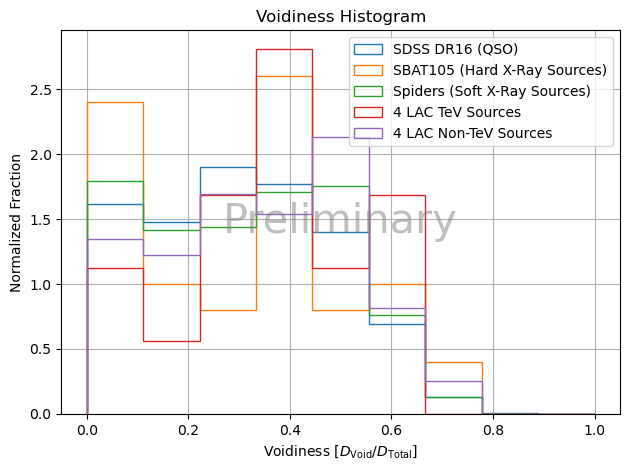

<Figure size 640x480 with 0 Axes>

In [51]:
# Everything to be plotted on the histogram will be appended to the master lisst
# if something needs to be changed for a specific histogram, edit the relavent 
# bit of code
# Base plotting code, the only thing we tweak is the data we're plotting.
# The bins and label

def custom_plot_hist(data, labels, bins, cumulative = False, density=None):

    if density == None:
        density = [True]*len(data)
        
    for dat, label, bin in zip(data, labels, bins):
        plt.hist([dat], 
            bins=bin, 
            histtype="step", 
            density=density, 
            stacked=False,
            label=label,
            cumulative=cumulative)
        
    plt.xlabel('Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]')
    plt.ylabel('Normalized Fraction')
    plt.title('Voidiness Histogram')

    plt.grid()

    plt.legend()

    plt.text(0.5, 0.5, 'Preliminary',  # Adjust the position as needed
                fontsize=30, color='gray', alpha=0.5,
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()


VOIDINESS_DATA = [] # list of panda series with voidiness data.
LABELS = []
BINS = []
# density = []
zbin = [0.1, 0.7]
def z_mask(df, zbin):
    return (df.z < zbin[1]) & (df.z >= zbin[0])

# 4LAC DATA
# VOIDINESS_DATA.append(four_lac.Voidiness)
# LABELS.append("4LAC")
# BINS.append(15)
# density.append(True)

# SDSS DR16 Optical Galaxies
VOIDINESS_DATA.append(sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)])
LABELS.append("SDSS DR16 (QSO)")
# BINS.append(45)
# density.append(True)

# SDSS DR16 Optical Galaxies
VOIDINESS_DATA.append(hard_xrays.Voidiness[z_mask(hard_xrays, zbin)])
LABELS.append("SBAT105 (Hard X-Ray Sources)")
BINS.append(15)

# Soft xrays ROMBAZCAT
VOIDINESS_DATA.append(soft_xrays.Voidiness[z_mask(soft_xrays, zbin)])
LABELS.append("Spiders (Soft X-Ray Sources)")
BINS.append(17)

# TEV Sources
tev_mask = four_lac.TeVflag == 1
VOIDINESS_DATA.append(four_lac[tev_mask].Voidiness[z_mask(four_lac[tev_mask], zbin)])
LABELS.append("4 LAC TeV Sources")
BINS.append(10)

# Non TEV Sources
VOIDINESS_DATA.append(four_lac[~is_tev].Voidiness[z_mask(four_lac[~is_tev], zbin)])
LABELS.append("4 LAC Non-TeV Sources")
BINS.append(10)
BINS = [np.linspace(0, 1, 10)] * 6
custom_plot_hist(VOIDINESS_DATA, LABELS, BINS, cumulative=False)
plt.savefig("Voidiness")

/Users/juiceable/mambaforge/envs/astropy-env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


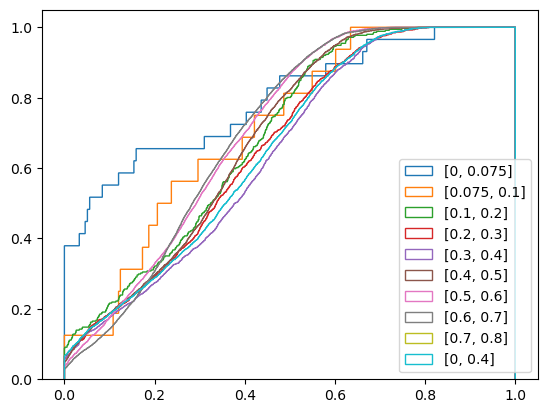

In [52]:
zbins = [ [0  , 0.075]
         ,[0.075, 0.1]
         ,[0.1, 0.2]
         ,[0.2, 0.3]
         ,[0.3, 0.4]
         ,[0.4, 0.5]
         ,[0.5, 0.6]
         ,[0.6, 0.7]
         ,[0.7, 0.8]
         ,[0, 0.4]]

start = 0
end = 1
num = 1000# Number of bins to plot the cdf curve in
plot_bins = np.linspace(start,end,num)
def z_mask(df, zbin):
    return (df.z < zbin[1]) & (df.z >= zbin[0])
n_normalbins = 10


for zbin in zbins:
    plt.hist(sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr],zbin )]
             , bins = plot_bins if cflag else n_normalbins
             , density=True
             , stacked = False
             , histtype='step'
             , label=repr(zbin)
             , cumulative=cflag)
plt.legend()

<Figure size 640x480 with 0 Axes>

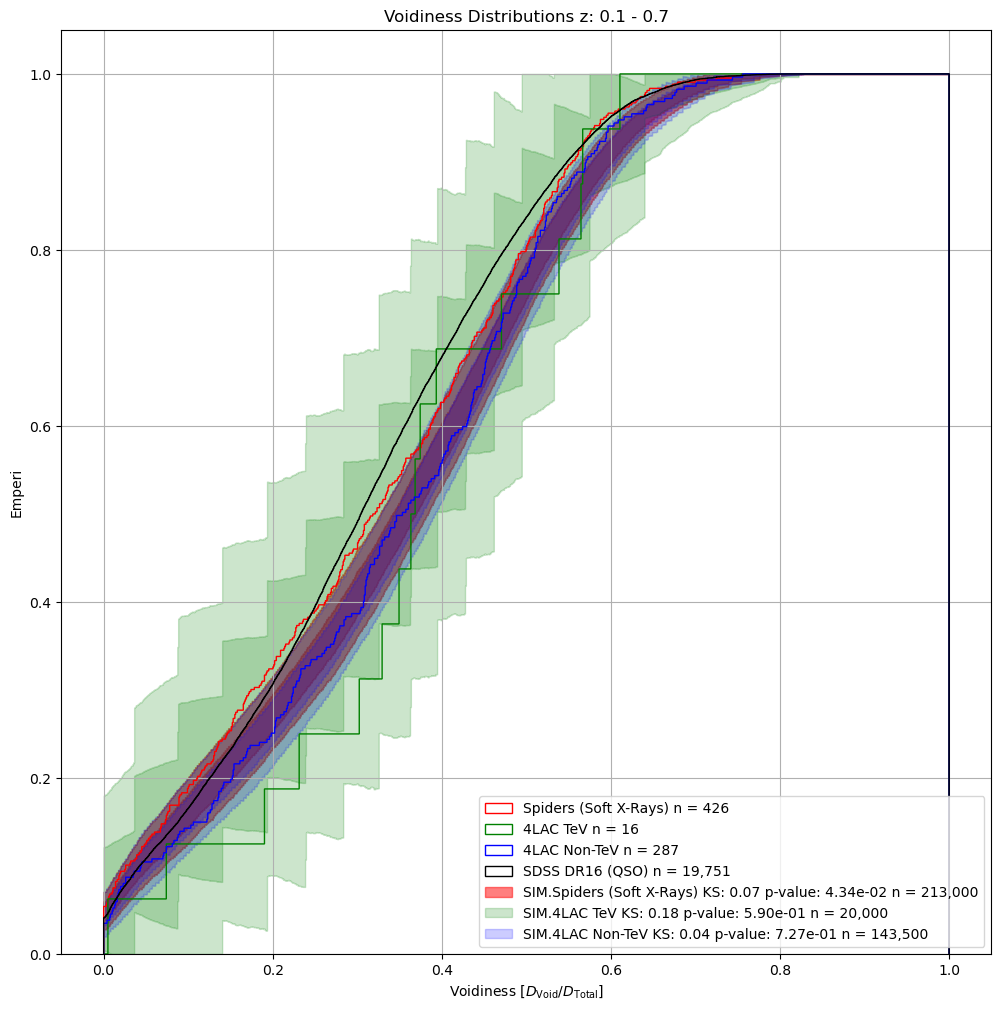

In [53]:
def z_mask(df, zbin):
    return (df.z < zbin[1]) & (df.z >= zbin[0])


zbins = [[0.1, 0.7]]

start = 0
end = 1
num = 1000# Number of bins to plot the cdf curve in
plot_bins = np.linspace(start,end,num)
n_normalbins = 10
plot_median = False
cflag = True
contour_alpha =  0.4
contour_c = 'r'


og_df = [soft_xrays, four_lac[is_tev], four_lac[~is_tev]]

sim_labels = ["Spiders (Soft X-Rays)"
        ,"4LAC TeV"
        ,"4LAC Non-TeV"
        # ,"SDSS DR16 (GLX)"
        # ,"Simulated Hard X-Rays"
]


labels = ["Spiders (Soft X-Rays)"
        ,"4LAC TeV"
        ,"4LAC Non-TeV"
        ,"SDSS DR16 (QSO)"
        ]
alphas = [0.5, 0.2, 0.2]


mc_data_zunbinned = [mc_soft_xrays
                    , mc_tev, mc_nontev]
# Because python is lazy evalated. this cause bugs. get_contour calls a functions that generates figure
# This was the only way I could figure out to force python to evaluate this list now so that no plot is created when i access contours later

contours = []
for zbin in zbins:
    cont_for_z = []
    for i in range(len(mc_data_zunbinned)):
        df = og_df[i]
        mc_d_ub = mc_data_zunbinned[i]
        cont_for_z.append(eval('get_contour(z_mask(df, zbin), mc_d_ub[get_sim_idx(mc_d_ub,df,zbin)], plot_bins, cflag)'))
    contours.append(cont_for_z)


dfs = [soft_xrays
      ,four_lac[is_tev]
      ,four_lac[~is_tev]]


cs = ['r', 'g', 'b', 'k']
for ii, zbin in enumerate(zbins):




    plt.figure(figsize=(12,12))
    curves = [soft_xrays.Voidiness[z_mask(soft_xrays,zbin)]
        ,four_lac[is_tev].Voidiness[z_mask(four_lac[is_tev], zbin)]
        ,four_lac[~is_tev].Voidiness[z_mask(four_lac[~is_tev], zbin)]
        ,sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr],zbin)]]
    for i in range(len(curves)):
        plt.hist(curves[i]
                    , bins = plot_bins if cflag else n_normalbins
                    , density=True
                    , stacked = False
                    , histtype='step'
                    , label=labels[i] + f" n = {len(curves[i]):,}"
                    , cumulative=cflag
                    , color = cs[i])

    for j, thing in enumerate(contours[ii]):
        ks, p = stats.ks_2samp(curves[j],
                               mc_data_zunbinned[j][get_sim_idx(mc_data_zunbinned[j]
                                                                ,dfs[j]
                                                                ,zbin)])  
        if plot_median:
            plt.plot(plot_bins[:-1],thing[0]
                     , label = "SIM." + sim_labels[j] + f" KS: {ks:.2f}" +  f" p-value: {p:.2e}" 
                     ,color = cs[j]                    
                     )
        for k, cont in enumerate(thing[1:3]):
            label = None if k%2 ==0  else "SIM." + sim_labels[j] + f" KS: {ks:.2f}" + f" p-value: {p:.2e}" + f" n = {len(mc_data_zunbinned[j][get_sim_idx(mc_data_zunbinned[j] ,dfs[j],zbin)]):,}"
            plt.fill_between(plot_bins[:-1], cont[0], cont[1]
                                    , step= "post"
                                    , alpha = alphas[j]
                                    , label = label
                                    , color = cs[j]
                                    #  , edgecolor = 'orange'
                                    )
        # plt.hist()



    plt.legend()
    plt.grid()                    
    plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
    if cflag: ylabel = 'Emperical Cumulative Distribution Function'
    else: ylabel = "Normalized Fraction"
    plt.ylabel('Emperi')
    title = f"Voidiness Distributions z: {zbin[0]} - {zbin[1]}" #+ \
            # f"\nKS: {ks:.2f}" + \
            # f"\np-value: {p:.2e}"
    fn = f"Voidiness Distributions z: {zbin[0]} - {zbin[1]}"
    plt.title(title)
    plt.savefig("stats/stats_fig/TeV_and_Friends" + fn + str("CDF" if cflag else "") + ".png", bbox_inches='tight')

In [54]:
for k, cont in enumerate(thing[1:3]):
    print(len(cont))

2
2


<Figure size 640x480 with 0 Axes>

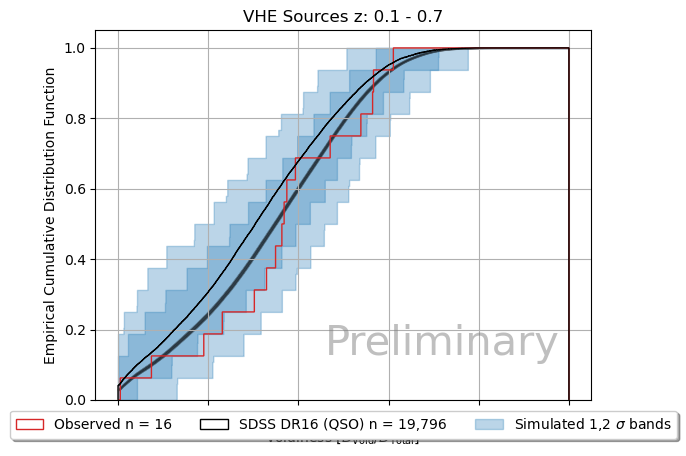

<Figure size 640x480 with 0 Axes>

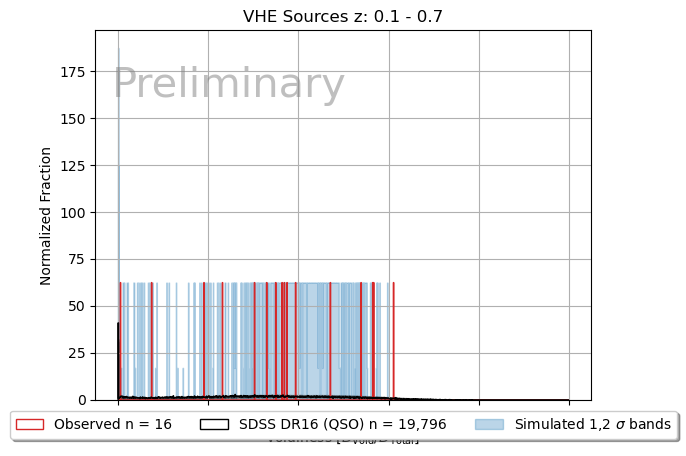

In [55]:
start = 0
end = 1
num = 1000
zbin = [0.1, 0.7]

binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
un_binned_real_df = four_lac[is_tev]
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]

observed_label = "Observed VHE "
observed_color = "tab:red"
len_data = len(observed_data)
mc_data = mc_tev
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]
plot_median = False
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = False
fill_btwn_c = 'tab:blue'
fill_alpha = 0.3
plot_sdss = False
sdss_color = "k"
# sdss_
# Plot parameters
title = f'VHE Sources z: {zbin[0]} - {zbin[1]}'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'Simulated VHE'

for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx= False
                    , plot_sdss_qsr= True
                    , save=True
                    ,legend_override=[f"Observed n = {len(observed_data):,}"
                                      ,f"SDSS DR16 (QSO) n = {len(sdss_dr16[is_qsr]):,}"
                                      , "Simulated 1,2 $\sigma$ bands"]
                    )
                    



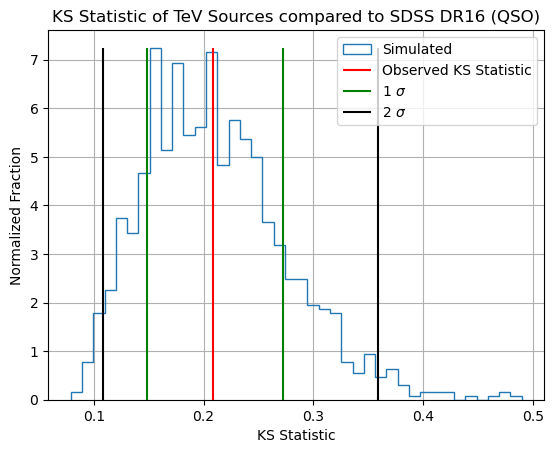

In [56]:
# 4lac TEV vs sdss

ks_stats = []
bins = 40

mc_data = mc_tev
stat_from_table = 0.209

len_data = len(four_lac[four_lac.TeVflag == 1])
for i in range(int(len(mc_data)/len_data)):
    ks_stats.append(stats.ks_2samp(sdss_dr16.Voidiness[is_qsr], mc_data[len_data*i:len_data*(i+1)])[0])


stats_on_stats = plt.hist(ks_stats, 
        bins = bins, 
        density=True, 
        stacked = False,
        histtype='step',
        cumulative=False,
        label="Simulated")
plt.ylabel("Normalized Fraction")
plt.xlabel("KS Statistic")
plt.title("KS Statistic of TeV Sources compared to SDSS DR16 (QSO)")
plt.grid()
vline_height = max(stats_on_stats[0])
plt.vlines(stat_from_table, 0, vline_height, color="r", label = "Observed KS Statistic") # Grabbed from KS_2samp table above.

for sig, c, l in zip([34.1, 34.1+13.6], ["green", "black"], ["1 $\sigma$", "2 $\sigma$"]):
    perc = np.percentile(ks_stats, [50-sig])
    plt.vlines(perc, 0, vline_height, label=l, color=c)
    perc = np.percentile(ks_stats, [50+sig])
    plt.vlines(perc, 0, vline_height, color=c)

plt.legend()
plt.savefig('stats/stats_fig/KSTeV.png')

In [57]:
len(four_lac)

328

In [58]:
len(mc_four_lac)/len(four_lac)

500.0

<Figure size 640x480 with 0 Axes>

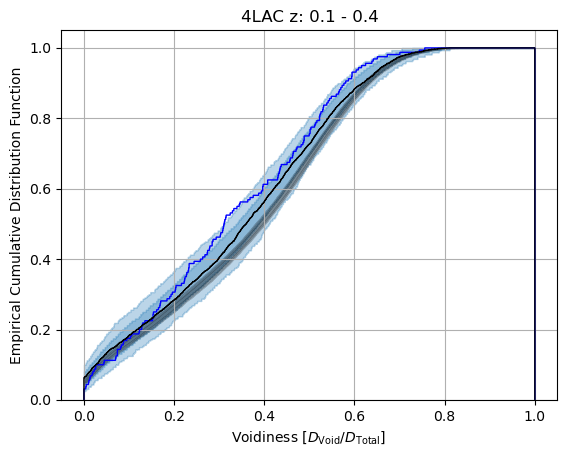

<Figure size 640x480 with 0 Axes>

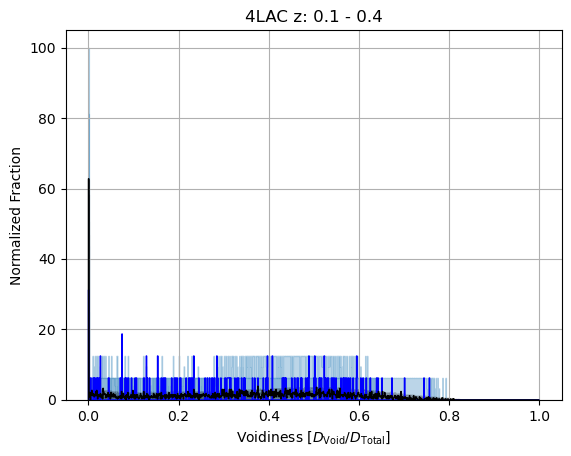

In [115]:
start = 0
end = 1
num = 1000
# zbin = [0.1, 0.35]
zbin = [0.1, 0.4]
# zbin = [0.4, 0.7]

binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
un_binned_real_df = four_lac
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]

observed_label = "Observed Four_lac"
observed_color = "blue"
len_data = len(observed_data)
mc_data = mc_four_lac
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]
plot_median = False
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = False
fill_btwn_c = 'tab:blue'
fill_alpha = 0.3
plot_sdss = False
sdss_color = "k"
# sdss_
# Plot parameters
title = f'4LAC z: {zbin[0]} - {zbin[1]}'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'Four Lac'

ks, p = stats.ks_2samp(observed_data, sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)])
for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx= False
                    , plot_sdss_qsr= True
                    , save=True
                    ,legend_override=[f"Observed n = {len(observed_data):,}\nKS: {ks:.2f}\np: {p:.2e}" 
                                      ,f"SDSS DR16 (QSO) n = {len(sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)]):,}"
                                      , "Simulated 1,2 $\sigma$ bands"]
                    ,zbin=zbin
                    ,sdss_num=1000 if cflag else 100
                    )
                    
# print(ks, p)
#jp

<Figure size 640x480 with 0 Axes>

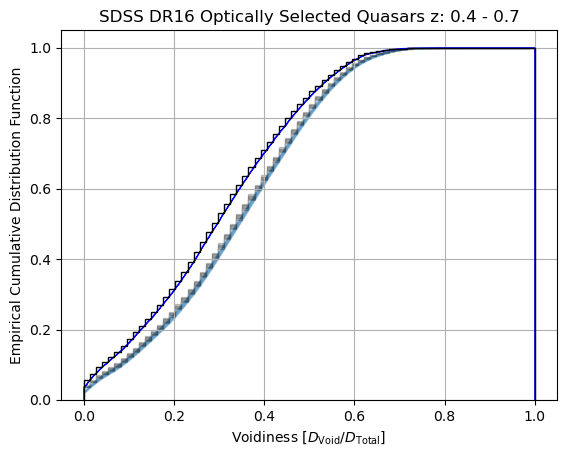

<Figure size 640x480 with 0 Axes>

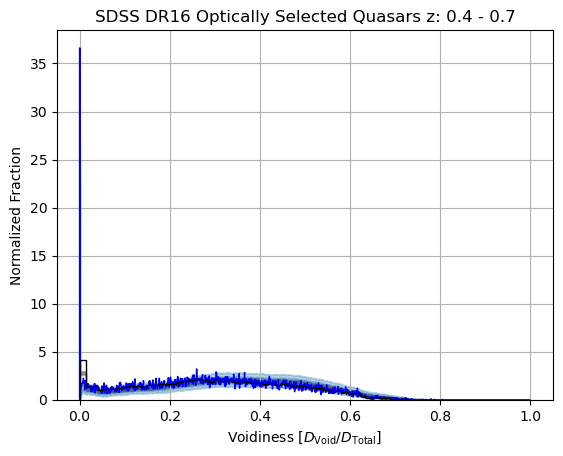

In [121]:
start = 0
end = 1
num = 1000
# zbin = [0.1, 0.35]
# zbin = [0.1, 0.4]
zbin = [0.4, 0.7]

binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
un_binned_real_df = sdss_dr16[is_qsr]
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]

observed_label = "Observed Four_lac"
observed_color = "blue"
len_data = len(observed_data)
mc_data = mc_sdss_qso
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]
plot_median = False
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = False
fill_btwn_c = 'tab:blue'
fill_alpha = 0.3
plot_sdss = False
sdss_color = "k"
# sdss_
# Plot parameters
title = f'SDSS DR16 Optically Selected Quasars z: {zbin[0]} - {zbin[1]}'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'Four Lac'

ks, p = stats.ks_2samp(observed_data, sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)])
for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx= False
                    , plot_sdss_qsr= True
                    , save=True
                    ,legend_override=[f"Observed n = {len(observed_data):,}\nKS: {ks:.2f}\np: {p:.2e}" 
                                      ,f"SDSS DR16 (QSO) n = {len(sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)]):,}"
                                      , "Simulated 1,2 $\sigma$ bands"]
                    ,zbin=zbin
                    ,sdss_num=75
                    ,plot_sdss_only=True
                    )
                    
# print(ks, p)
#jp

Text(0.5, 0, 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]')

<Figure size 640x480 with 0 Axes>

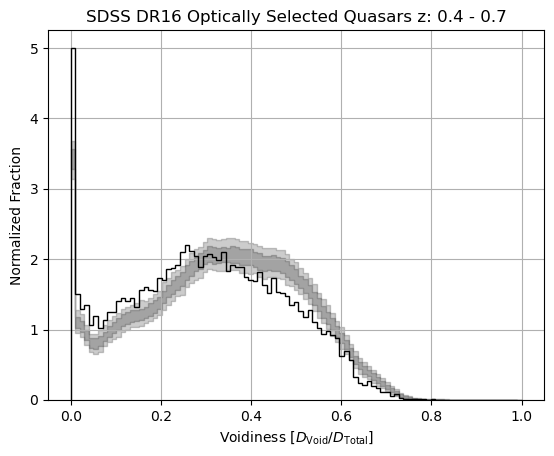

In [131]:
# zbin = [0.1, 0.4]
zbin=[0.4, 0.7]
sdss_num = 100
binning = np.linspace(0, 1, sdss_num)
cflag = False

BIN_IT = mc_sdss_qso[get_sim_idx(mc_sdss_qso, sdss_dr16[is_qsr], zbin)]
LEN = len(sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)])

sdss_sim_bin_heights = ret_sim_bin_heights(BIN_IT, LEN, np.linspace(0,1,sdss_num), cflag, show = show_sim_overlay)
plt.figure()
org = []
for i in range(sdss_num-1):
    org.append([[heights[i] for heights in sdss_sim_bin_heights]])

medians = []
for i in range(sdss_num-1):
    medians.append(np.median(org[i]))

# ks, p = stats.ks_2samp(observed_data, mc_data)
# ks_obv, p_obv = stats.ks_2samp(observed_data)
# Plot the sigma bands
lab = ['1 $\sigma$', '2 $\sigma$']
ii = 0
for s, l in zip(sigma_vals, lab):
    hi_sig = []
    low_sig = []
    for i in range(sdss_num-1):
        # Calculate the upper 1 sigma
        hi_sig.append(np.percentile(org[i], [50 + s])[0])
        # Lower
        low_sig.append(np.percentile(org[i], [50 - s])[0])
    if ii %2 == 0:
        l = None
    plt.fill_between(np.linspace(0,1,sdss_num)[:-1], hi_sig, low_sig
                    , step="post"
                    , alpha = 0.2
                    , color = 'k'
                    , label=l
                    #  , edgecolor = 'orange'
                    )
    ii += 1

un_binned_real_df = sdss_dr16[is_qsr]
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]
len_data = len(observed_data)
mc_data = mc_sdss_qso
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]

plt.hist(observed_data, color='k', histtype="step", density=True, bins = binning)

# Contour
plt.grid()
plt.title(f'SDSS DR16 Optically Selected Quasars z: {zbin[0]} - {zbin[1]}')
plt.ylabel('Normalized Fraction')
plt.xlabel('Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]')

<Figure size 640x480 with 0 Axes>

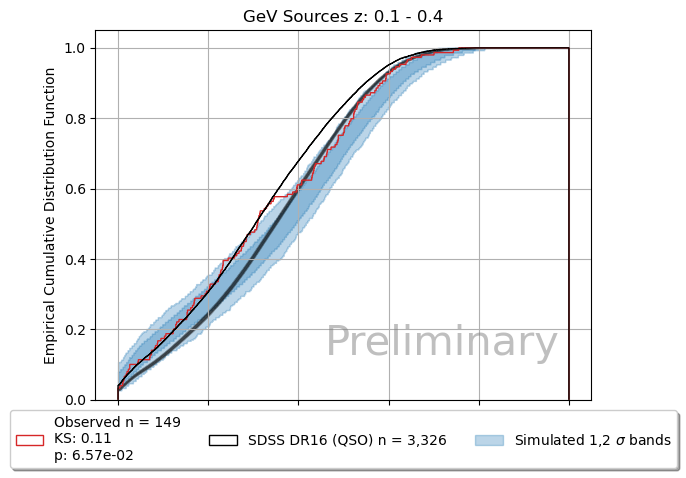

<Figure size 640x480 with 0 Axes>

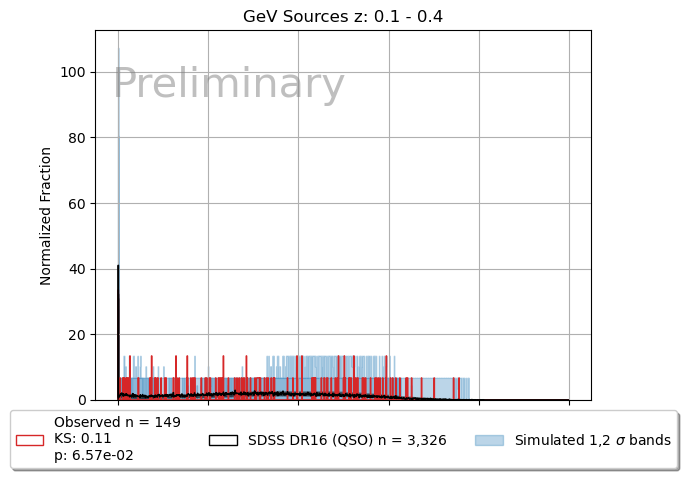

In [61]:
start = 0
end = 1
num = 1000
# zbin = [0.1, 0.35]
zbin = [0.1, 0.4]
# zbin = [0.4, 0.7]

binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
un_binned_real_df = four_lac[~is_tev]
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]

observed_label = "Observed TeV"
observed_color = "tab:red"
len_data = len(observed_data)
mc_data = mc_nontev
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]
plot_median = False
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = False
fill_btwn_c = 'tab:blue'
fill_alpha = 0.3
plot_sdss = False
sdss_color = "k"
# sdss_
# Plot parameters
title = f'GeV Sources z: {zbin[0]} - {zbin[1]}'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'Simulated GeV'

ks, p = stats.ks_2samp(observed_data, sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)])
for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx= False
                    , plot_sdss_qsr= True
                    , save=True
                    ,legend_override=[f"Observed n = {len(observed_data):,}\nKS: {ks:.2f}\np: {p:.2e}" 
                                      ,f"SDSS DR16 (QSO) n = {len(sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)]):,}"
                                      , "Simulated 1,2 $\sigma$ bands"]
                    )
                    
# print(ks, p)


In [62]:
len(observed_data)

149

In [64]:
# plt.hist([sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], [0.1])].Voidiness], cumulative=True, histtype="step")
# plt.hist([sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)].Voidiness], cumulative=True, histtype="step")

In [65]:
81000/162

500.0

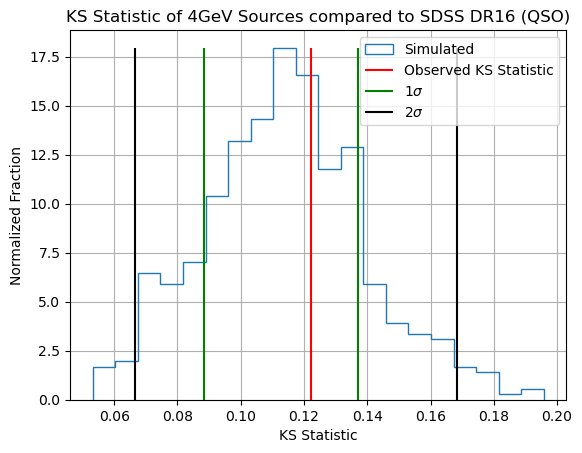

In [66]:
# 4lac TEV vs sdss

ks_stats = []
bins = 20

mc_data = mc_nontev
stat_from_table = 0.1222

len_data = len(four_lac[np.isnan(four_lac.TeVflag)])
for i in range(int(len(mc_data)/len_data)):
    ks_stats.append(stats.ks_2samp(sdss_dr16.Voidiness[is_qsr], mc_data[len_data*i:len_data*(i+1)])[0])


stats_on_stats = plt.hist(ks_stats, 
        bins = bins, 
        density=True, 
        stacked = False,
        histtype='step',
        cumulative=False,
        label="Simulated")
plt.ylabel("Normalized Fraction")
plt.xlabel("KS Statistic")
plt.title("KS Statistic of 4GeV Sources compared to SDSS DR16 (QSO)")
plt.grid()
vline_height = max(stats_on_stats[0])
plt.vlines(stat_from_table, 0, vline_height, color="r", label = "Observed KS Statistic") # Grabbed from KS_2samp table above.

for sig, c, l  in zip([34.1, 34.1+13.6], ["green", "black"], ["1$\sigma$","2$\sigma$"]):
    perc = np.percentile(ks_stats, [50-sig])
    plt.vlines(perc, 0, vline_height, label=l, color=c)
    perc = np.percentile(ks_stats, [50+sig])
    plt.vlines(perc, 0, vline_height, color=c)

plt.legend()
plt.savefig('stats/stats_fig/KSNonTeV.png')

<Figure size 640x480 with 0 Axes>

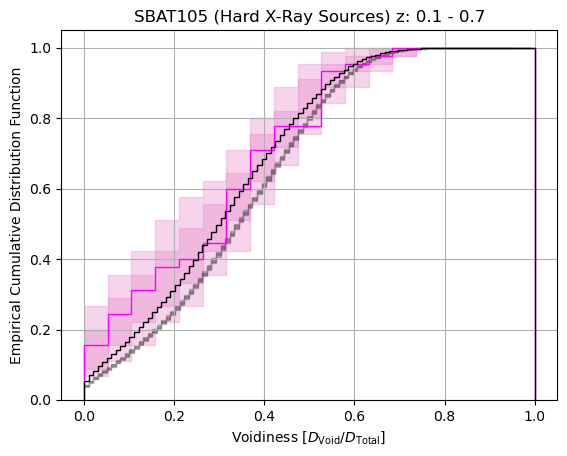

<Figure size 640x480 with 0 Axes>

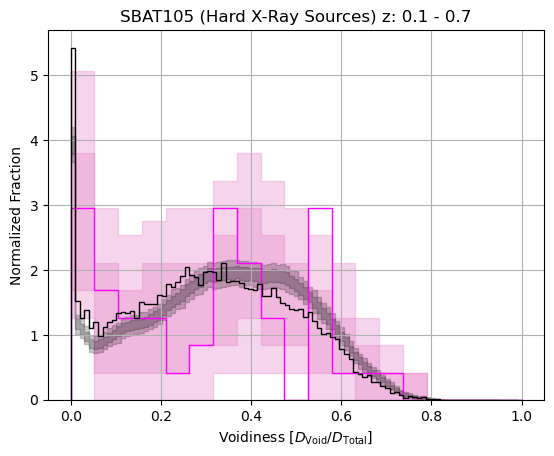

In [138]:
start = 0
end = 1
num = 20
zbin = [0.1, 0.7]

binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
un_binned_real_df = hard_xrays
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]

observed_label = "Observed TeV"
observed_color = "magenta"
len_data = len(observed_data)
mc_data = mc_hard_xrays
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]
plot_median = False
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = False
fill_btwn_c = 'tab:pink'
fill_alpha = 0.3
plot_sdss = False
sdss_color = "k"
# sdss_
# Plot parameters
title = f'SBAT105 (Hard X-Ray Sources) z: {zbin[0]} - {zbin[1]}'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'Simulated SBAT 105'

for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx= False
                    , plot_sdss_qsr= True
                    , save=True
                    ,legend_override=[f"Observed n = {len(observed_data):,}"
                                      ,f"SDSS DR16 (QSO) n = {len(sdss_dr16[is_qsr]):,}"
                                      , "Simulated 1,2 $\sigma$ bands"]
                    ,zbin=zbin
                    )
                    



<Figure size 640x480 with 0 Axes>

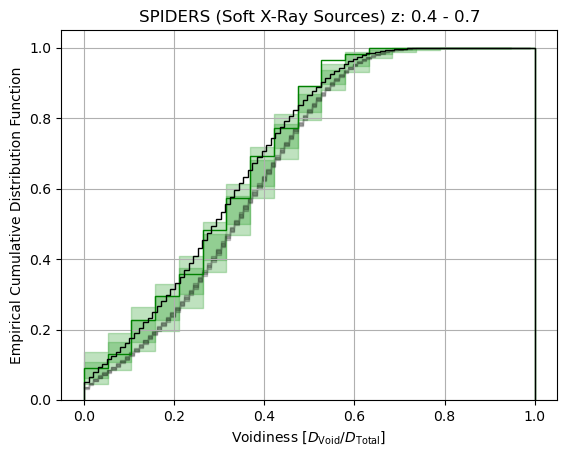

<Figure size 640x480 with 0 Axes>

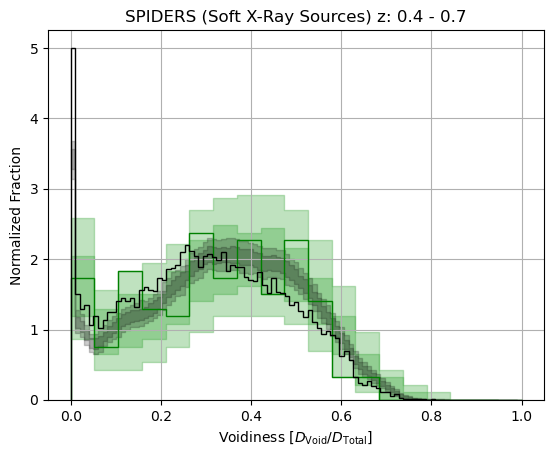

In [139]:
start = 0
end = 1
num = 20
# zbin = [0.1, 0.4]
zbin = [0.4, 0.7]

binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
un_binned_real_df = soft_xrays
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]

observed_label = "Observed TeV"
observed_color = "green"
len_data = len(observed_data)
mc_data = mc_soft_xrays
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]
plot_median = False
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = False
fill_btwn_c = 'tab:green'
fill_alpha = 0.3
plot_sdss = False
sdss_color = "k"
# sdss_
# Plot parameters
title = f'SPIDERS (Soft X-Ray Sources) z: {zbin[0]} - {zbin[1]}'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'SPIDERS'
ks, p = stats.ks_2samp(observed_data, sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)])
for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx= False
                    , plot_sdss_qsr= True
                    , save=True
                    ,legend_override=[f"Observed n = {len(observed_data):,}\nKS: {ks:.2f}\np: {p:.2e}" 
                                      ,f"SDSS DR16 (QSO) n = {len(sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)]):,}"
                                      , "Simulated 1,2 $\sigma$ bands"]
                    ,zbin = zbin
                    )
                    



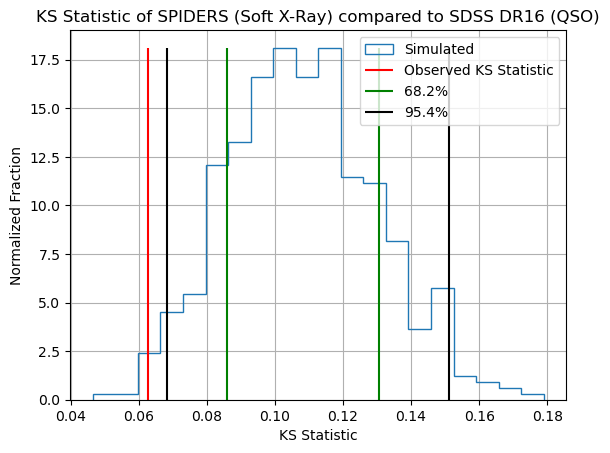

In [69]:
# 4lac TEV vs sdss

ks_stats = []
bins = 20

mc_data = mc_soft_xrays
stat_from_table = 0.0628

len_data = len(soft_xrays)
for i in range(int(len(mc_data)/len_data)):
    ks_stats.append(stats.ks_2samp(sdss_dr16.Voidiness[is_qsr], mc_data[len_data*i:len_data*(i+1)])[0])


stats_on_stats = plt.hist(ks_stats, 
        bins = bins, 
        density=True, 
        stacked = False,
        histtype='step',
        cumulative=False,
        label="Simulated")
plt.ylabel("Normalized Fraction")
plt.xlabel("KS Statistic")
plt.title("KS Statistic of SPIDERS (Soft X-Ray) compared to SDSS DR16 (QSO)")
plt.grid()
vline_height = max(stats_on_stats[0])
plt.vlines(stat_from_table, 0, vline_height, color="r", label = "Observed KS Statistic") # Grabbed from KS_2samp table above.

for sig, c in zip([34.1, 34.1+13.6], ["green", "black"]):
    perc = np.percentile(ks_stats, [50-sig])
    plt.vlines(perc, 0, vline_height, label=f'{sig*2}%', color=c)
    perc = np.percentile(ks_stats, [50+sig])
    plt.vlines(perc, 0, vline_height, color=c)

plt.legend()
plt.savefig('stats/stats_fig/KSSoftXrays.png')

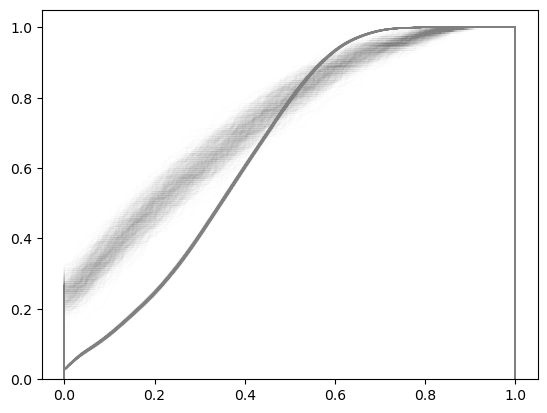

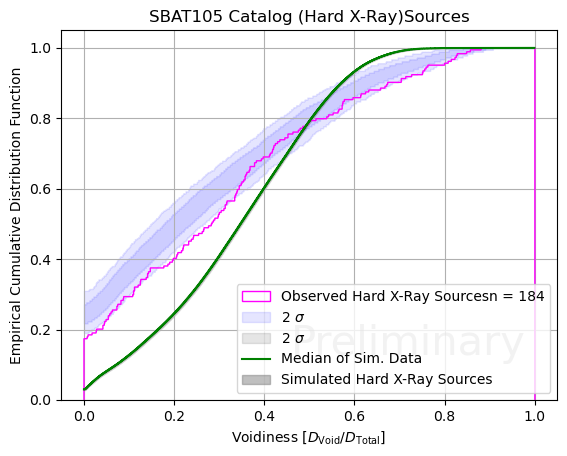

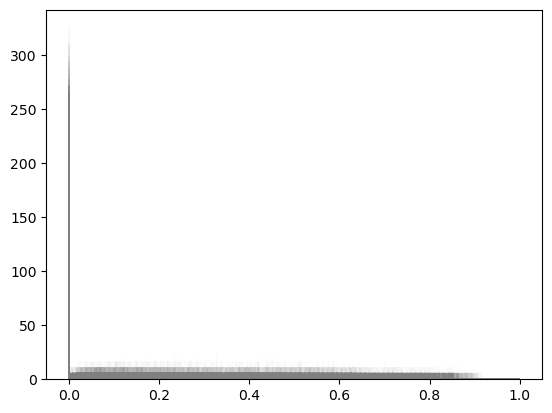

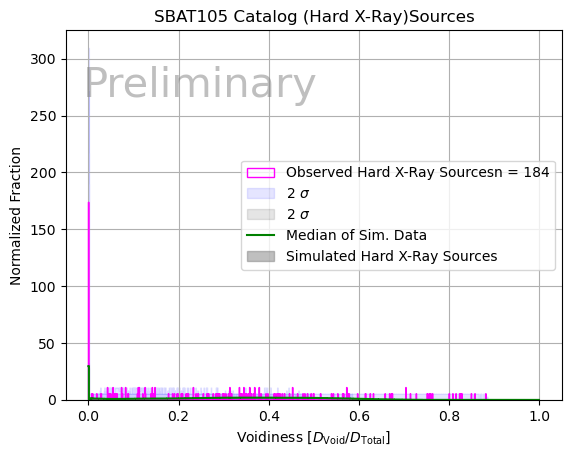

In [70]:
start = 0
end = 1
num = 1000
binning = np.linspace(start,end,num)

sigma_vals = [34.1, 34.1+13.6]
observed_data = hard_xrays.Voidiness
observed_label = "Observed Hard X-Ray Sources"
observed_color = "magenta"
len_data = len(observed_data)
mc_data = mc_hard_xrays
plot_median = True
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = True
fill_btwn_c = 'b'
fill_alpha = 0.1
plot_sdss = True
sdss_color = 'k'
title = 'SBAT105 Catalog (Hard X-Ray)Sources'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'Simulated Hard X-Ray Sources'

for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx=False
                    , plot_sdss_qsr=False
                    )

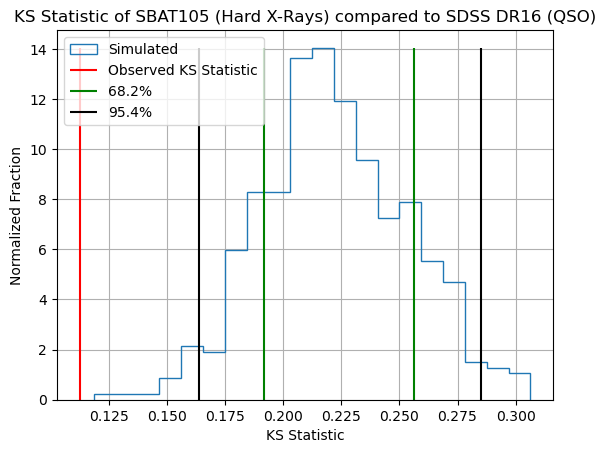

In [71]:
# 4lac TEV vs sdss

ks_stats = []
bins = 20

mc_data = mc_hard_xrays
stat_from_table = 0.1124

len_data = len(hard_xrays)
for i in range(int(len(mc_data)/len_data)):
    ks_stats.append(stats.ks_2samp(sdss_dr16.Voidiness[is_qsr], mc_data[len_data*i:len_data*(i+1)])[0])


stats_on_stats = plt.hist(ks_stats, 
        bins = bins, 
        density=True, 
        stacked = False,
        histtype='step',
        cumulative=False,
        label="Simulated")
plt.ylabel("Normalized Fraction")
plt.xlabel("KS Statistic")
plt.title("KS Statistic of SBAT105 (Hard X-Rays) compared to SDSS DR16 (QSO)")
plt.grid()
vline_height = max(stats_on_stats[0])
plt.vlines(stat_from_table, 0, vline_height, color="r", label = "Observed KS Statistic") # Grabbed from KS_2samp table above.

for sig, c, l in zip([34.1, 34.1+13.6], ["green", "black"], ["1 $\sigma$", "2 $\sigma$"]):
    perc = np.percentile(ks_stats, [50-sig])
    plt.vlines(perc, 0, vline_height, label=f'{sig*2}%', color=c)
    perc = np.percentile(ks_stats, [50+sig])
    plt.vlines(perc, 0, vline_height, color=c)

plt.legend()
plt.savefig('stats/stats_fig/KSHardXrays.png')
# JP

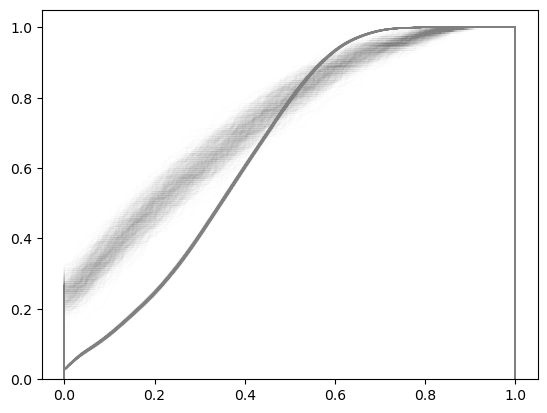

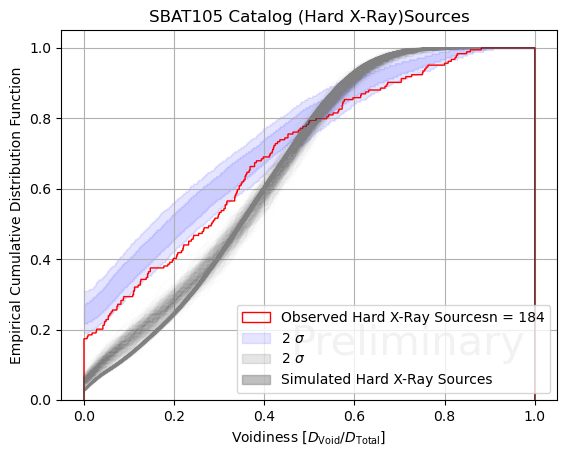

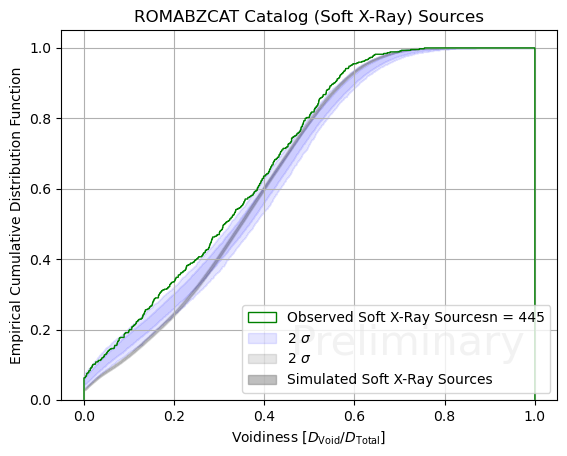

In [72]:
# Plot the xrays together

# Common variables~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start = 0
end = 1
num = 1000
binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
plot_median = False
cflag = True
show_sim_overlay = True
fill_btwn_c = 'b'
fill_alpha = 0.1
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# MASTER LISTS
observed_data  = [] 
observed_label = [] 
observed_color = [] 
len_data       = [] 
mc_data        = []
median_c       = [] 
title          = [] 
appended_label = [] 
all_sim_c = []

# HARD X-RAYS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observed_data.append(hard_xrays.Voidiness)
observed_label.append("Observed Hard X-Ray Sources")
observed_color.append("red")
len_data.append(len(hard_xrays.Voidiness))
mc_data.append(mc_hard_xrays)
median_c.append('magenta')
title.append('SBAT105 Catalog (Hard X-Ray)Sources')
appended_label.append('Simulated Hard X-Ray Sources')
all_sim_c.append('cyan')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SOFT X-RAYS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observed_data.append(soft_xrays.Voidiness)
observed_label.append("Observed Soft X-Ray Sources")
observed_color.append("green")
len_data.append(len(soft_xrays.Voidiness))
mc_data.append(mc_soft_xrays)
median_c.append('cyan')
title.append('ROMABZCAT Catalog (Soft X-Ray) Sources')
appended_label.append('Simulated Soft X-Ray Sources')
all_sim_c.append('magenta')
 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for od, ol, oc, ld, md, mc, t, al, alc in zip(observed_data
                                          ,observed_label
                                          ,observed_color
                                          ,len_data
                                          ,mc_data
                                          ,median_c
                                          ,title
                                          ,appended_label,
                                          all_sim_c):
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , od
                    , ol
                    , oc
                    , ld
                    , md
                    , plot_median
                    , mc
                    , cflag
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , t
                    , xlabel
                    , ylabel
                    , al
                    , plot_sdss_glx=False
                    , plot_sdss_qsr=False
                    ,all_sim_c=alc
                    )



In [ ]:
start = 0
end = 1
num = 100
zbin = [0.1, 0.4]
# zbin = [0.4, 0.7]

binning = np.linspace(start,end,num)
sigma_vals = [34.1, 34.1+13.6]
un_binned_real_df = sdss_dr16[is_qsr]
observed_data = un_binned_real_df.Voidiness[z_mask(un_binned_real_df, zbin)]

observed_label = "Observed TeV"
observed_color = "tab:red"
len_data = len(observed_data)
mc_data = mc_sdss_qso
mc_data = mc_data[get_sim_idx(mc_data,un_binned_real_df, zbin)]
plot_median = False
median_c = 'g'
cflag = True # cumulative
show_sim_overlay = False
fill_btwn_c = 'tab:blue'
fill_alpha = 0.3
plot_sdss = False
sdss_color = "k"
# sdss_
# Plot parameters
title = f'SPIDERS (Soft X-Ray Sources) z: {zbin[0]} - {zbin[1]}'
xlabel = 'Voidiness [$D_{\\rm Void}/D_{\\rm Total}$] '
ylabel = 'Normalized Fraction'
appended_label = 'SPIDERS'
ks, p = stats.ks_2samp(observed_data, sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)])
for oof in [True, False]:
    plt.figure()
    plot_everything(num
                    ,binning
                    , sigma_vals
                    , observed_data
                    , observed_label
                    , observed_color
                    , len_data
                    , mc_data
                    , plot_median
                    , median_c
                    , oof
                    , show_sim_overlay
                    , fill_btwn_c
                    , fill_alpha
                    , title
                    , xlabel
                    , ylabel
                    , appended_label
                    , plot_sdss_glx= False
                    , plot_sdss_qsr= True
                    , save=True
                    ,legend_override=[f"Observed n = {len(observed_data):,}\nKS: {ks:.2f}\np: {p:.2e}" 
                                      ,f"SDSS DR16 (QSO) n = {len(sdss_dr16[is_qsr][z_mask(sdss_dr16[is_qsr], zbin)]):,}"
                                      , "Simulated 1,2 $\sigma$ bands"]
                    ,zbin = zbin
                    ,plot_sdss_only = True
                    )
                    



Text(0.5, 1.0, 'SDSS DR 16 (QSO)')

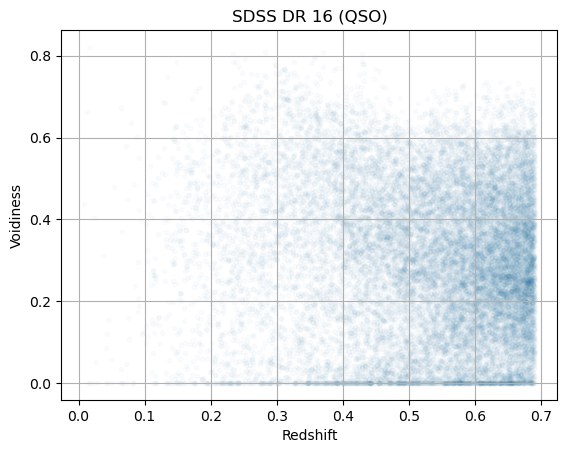

In [73]:
plt.figure()
plt.scatter(sdss_dr16.z[is_qsr], sdss_dr16.Voidiness[is_qsr], marker = '.', alpha = 0.02)
# plt.xlim((0.3616,0.3618))
# plt.ylim((0.524, 0.575))
plt.ylabel("Voidiness")
plt.xlabel("Redshift")
plt.grid()
plt.title("SDSS DR 16 (QSO)")

Text(0.5, 1.0, 'SDSS DR 16 (GLX)')

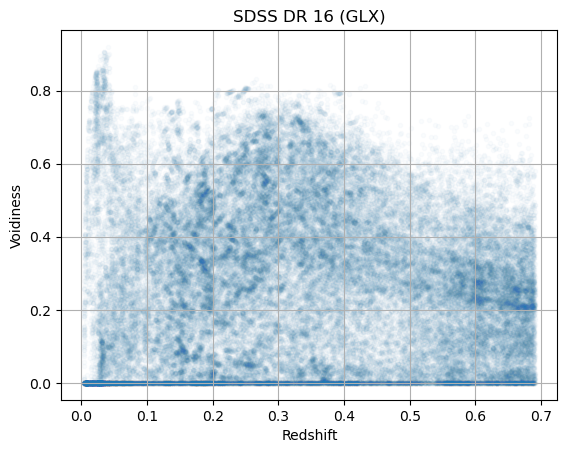

In [74]:
plt.figure()
plt.scatter(sdss_dr16.z[is_glx], sdss_dr16.Voidiness[is_glx], marker = '.', alpha = 0.02)
# plt.xlim((0.3616,0.3618))
# plt.ylim((0.524, 0.575))
plt.ylabel("Voidiness")
plt.xlabel("Redshift")
plt.grid()
plt.title("SDSS DR 16 (GLX)")

Text(0.5, 1.0, 'haRD XRYA\nPearson Correlation Coeff: 0.066\np-value: 0.373')

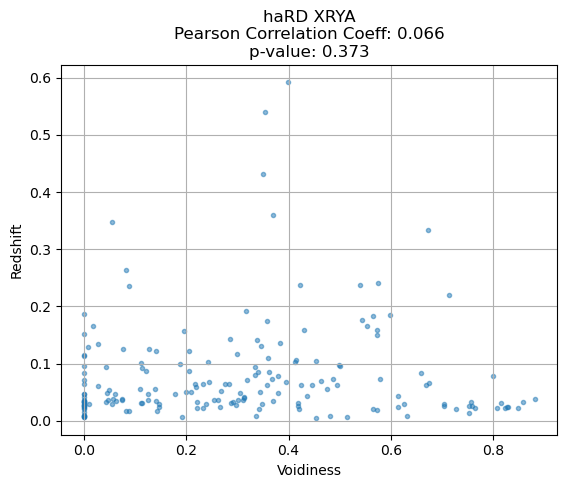

In [75]:
plt.figure()
# plt.scatter(hard_xrays.z, hard_xrays.Voidiness, marker = '.', alpha = 0.5)
plt.scatter(hard_xrays.Voidiness, hard_xrays.z, marker = '.', alpha = 0.5)
# plt.scatter(soft_xrays.z, )
# plt.xlim((0.3616,0.3618))
# plt.ylim((0.524, 0.575))
plt.xlabel("Voidiness")
plt.ylabel("Redshift")
# plt.ylim((0.000001, 0.2))
plt.grid()

corr_test= stats.pearsonr(hard_xrays.Voidiness, hard_xrays.z)
plt.title(f"haRD XRYA"+
          f"\nPearson Correlation Coeff: {corr_test[0]:.3f}"+
          f"\np-value: {corr_test[1]:.3f}")

Text(0.5, 1.0, 'soFt XRYA')

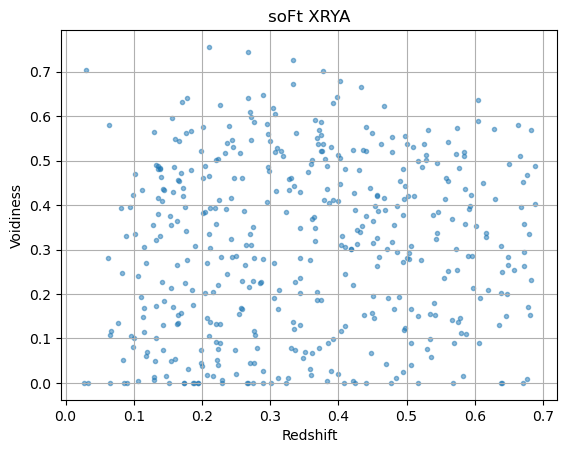

In [76]:
plt.figure()
plt.scatter(soft_xrays.z, soft_xrays.Voidiness, marker = '.', alpha = 0.5)
# plt.xlim((0.3616,0.3618))
# plt.ylim((0.524, 0.575))
plt.ylabel("Voidiness")
plt.xlabel("Redshift")
plt.grid()
plt.title("soFt XRYA")

Text(0, 0.5, 'Normalized Fraction')

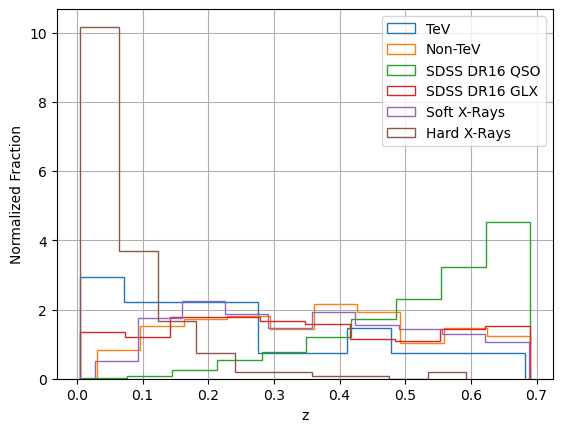

In [77]:
data = [four_lac.z[is_tev].copy()
        , four_lac.z[~is_tev].copy()
        , sdss_dr16.z[is_qsr].copy()
        , sdss_dr16.z[is_glx].copy()
        , soft_xrays.z
        , hard_xrays.z]
labels = ["TeV"
          , "Non-TeV"
          , "SDSS DR16 QSO"
          , "SDSS DR16 GLX"
          , "Soft X-Rays"
          , "Hard X-Rays"]
for hm, l, b in zip(data, labels, [10, 10, 10, 10, 10, 10]):
    plt.hist(hm
             ,bins = b
             ,histtype="step"
             ,cumulative=False
             ,label = l
             , density=True
             ,stacked=False
             )
plt.legend()
plt.grid()
plt.xlabel("z")
plt.ylabel("Normalized Fraction")

Redshift vs. Voidiness Analysis

In [93]:
def void_vs_z(df,title=None, bins = np.linspace(0, 0.7, 8), colors = None, label=None, alpha = 0.1):
    # fig, ax = plt.figure()
    lbools = ret_bin_bools(df, bins)


    # Returns step function of the contours
    med, one_sig, two_sig =  ret_mid_low_hi(df, lbools)
    bin_centers = [(bins[i+1]+ bins [i])/2 for i in range(len(bins)-1)]
    # Plot the median
    left_bins = np.append(bins[:-1], bins[-1]) # Adding that last post from the fencepost problem
    med = np.append(med, med[-1])    
    right_bins = bins[1:]

    plt.step(left_bins,med,where='post', label="Median")

    # Plot the sigma contours
    aah = 0
    for s ,l in zip([one_sig, two_sig], [1, 2]):
        # Fixing fencepost problem
        temp1 = np.append(s[0], s[0][-1])
        temp2 = np.append(s[1], s[1][-1])
        label = "1, 2 $\sigma$" if aah%2 == 0 else None
        plt.fill_between(left_bins, temp1, temp2
                        , step="post"
                        , alpha = 0.4
                        , color = 'g'
                        , label=label
                        #  , edgecolor = 'orange'
                        )
        aah +=1
    for boolean in lbools:
        if colors is None:
            plt.scatter(df.z[boolean], df.Voidiness[boolean]
                        ,label=label
                        , alpha=alpha
                        , marker='.',
                        c='k')
        else:
            plt.scatter(df.z[boolean], df.Voidiness[boolean]
                        ,label=label
                        , alpha=alpha
                        , marker='.'
                        , c=colors)
    plt.xlabel('z')
    plt.ylabel('Voidiness')

    # # ax = plt.gca()
    # legends = ax.get_legend()
    # if legends is not None:
    plt.legend()
    
    if title is not None:
        plt.title(title)
    plt.grid()

def ret_bin_bools(df, bins):
    """Returns list of booleans where the rows fall between the bin edges.
    FILTERS BY REDSHIFT"""
    lbools = []
    for i in range(len(bins)-1):
        lbools.append((df.z < bins[i+1]) & (df.z > bins[i]))
    return lbools

def ret_mid_low_hi(df, lbools):
    """Measured at the 84.1 percentile and 95th percentil. 
    May not be accurate for low statistics"""
    meds = []
    one_sig_lo = []
    one_sig_hi = []
    two_sig_lo  = []
    two_sig_hi = []
    for lb in lbools:
        # GOD AWFUL
        try:
            meds.append(np.median(df.Voidiness[lb]))
        except:
            meds.append(None)
        try:
            one_sig_hi.append(np.percentile(df.Voidiness[lb], 50+34.1))        
        except:
            one_sig_hi.append(None)
        try:
            two_sig_hi.append(np.percentile(df.Voidiness[lb], 50+34.1+13.6))
        except:
            two_sig_hi.append(None)
        try:
            one_sig_lo.append(np.percentile(df.Voidiness[lb], 50-34.1))
        except:
            one_sig_lo.append(None)
        try:
            two_sig_lo.append(np.percentile(df.Voidiness[lb], 50-34.1-13.6))
        except:
            two_sig_lo.append(None)
            
    return (meds, [one_sig_hi, one_sig_lo], [two_sig_hi, two_sig_lo])

def ret_mid_1s_2s(df, lbools):
    meds = []
    one_sig_lo = []
    one_sig_hi = []
    two_sig_lo  = []
    two_sig_hi = []
    for lb in lbools:
        data = df.Voidiness[lb]
        med = np.median(data)
        meds.append(med)
        sigma = np.std(data)
        one_sig_hi.append(med+sigma)
        one_sig_lo.append(med-sigma)
        two_sig_hi.append(med+2*sigma)
        two_sig_lo.append(med-2*sigma)


    return (meds, [one_sig_hi, one_sig_lo], [two_sig_hi, two_sig_lo])

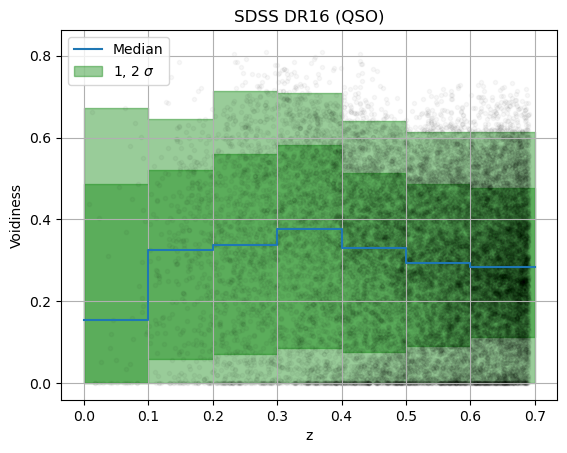

In [94]:
void_vs_z(sdss_dr16[is_qsr],alpha=0.03, title="SDSS DR16 (QSO)")

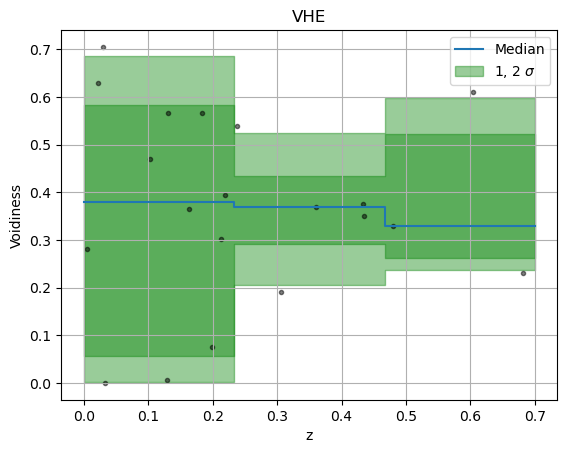

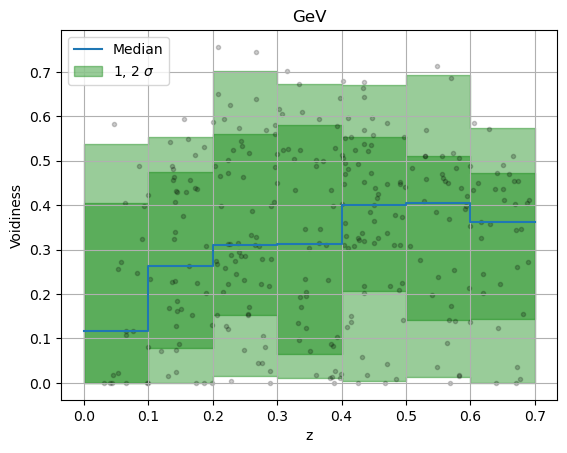

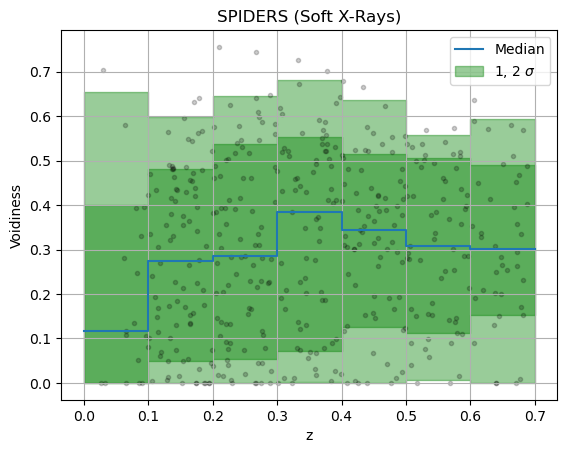

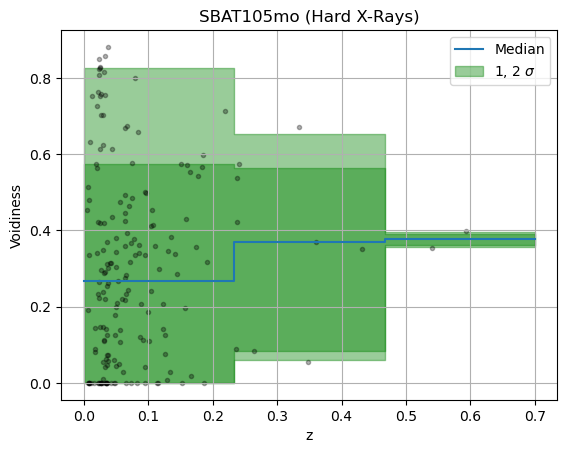

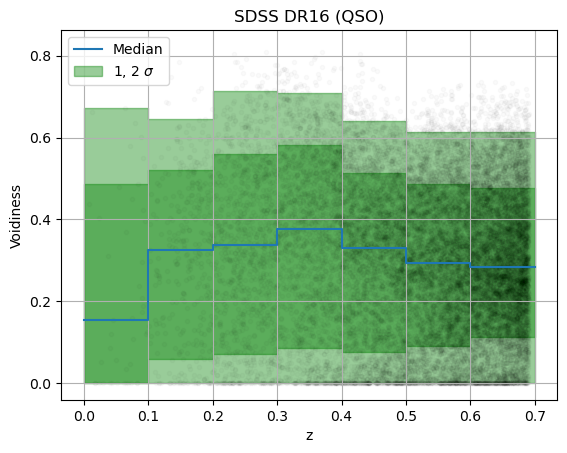

In [95]:
data = [four_lac[is_tev]
        , four_lac[~is_tev]
        , soft_xrays
        , hard_xrays
        , sdss_dr16[is_qsr]
        # , sdss_dr16[is_glx]
        ]
titles = ["VHE"
          , "GeV"
          , "SPIDERS (Soft X-Rays)"
          , "SBAT105mo (Hard X-Rays)"
          , "SDSS DR16 (QSO)"
        #   , "SDSS DR16 (GLX)"
          ]
alphas = [0.5
          ,0.2
          ,0.2
          ,0.3
          ,0.02
          ,0.03]

n_bins = [4, 8, 8, 4, 8]
for i in range(len(data)):
    plt.figure()
    temp_data = data[i]
    corr_test= stats.pearsonr(temp_data.z, temp_data.Voidiness)
    temp_title = titles[i] #+ \
        #   f"\nPearson Correlation Coeff: {corr_test[0]:.3e}"+ \
        #   f"\np-value: {corr_test[1]:.3e}"

    void_vs_z(data[i], title=temp_title, alpha=alphas[i], bins=np.linspace(0, 0.7, n_bins[i]))
    plt.savefig("stats/stats_fig/z_vs_voidiness"+titles[i]+".png")        

    


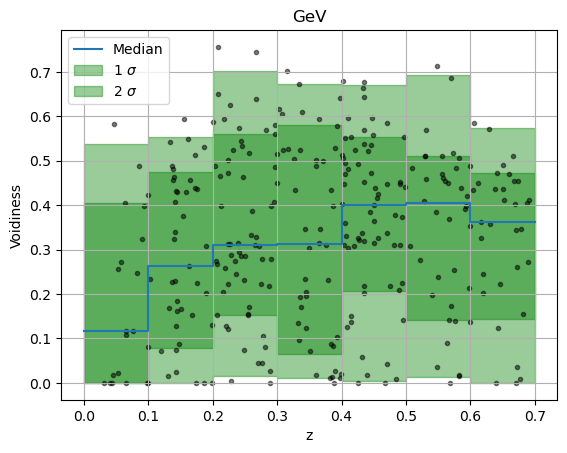

In [81]:
void_vs_z(four_lac[~is_tev], title="GeV", alpha=0.5)

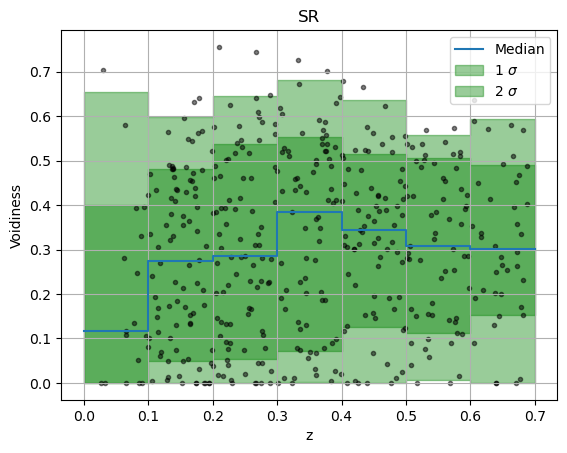

In [82]:
void_vs_z(soft_xrays, title="SR", alpha=0.5)

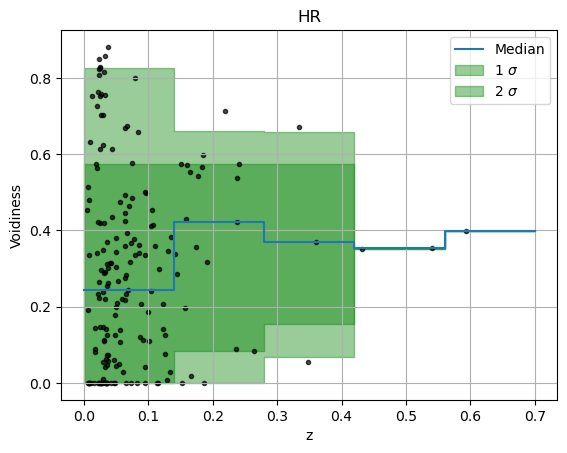

In [83]:
void_vs_z(hard_xrays, title="HR", alpha= 0.7, bins=np.linspace(0,0.7,6))

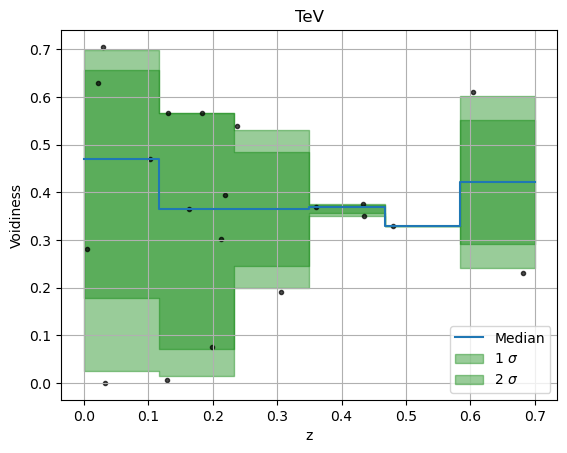

In [84]:
void_vs_z(four_lac[is_tev], title="TeV", alpha= 0.7, bins=np.linspace(0,0.7,7))

In [85]:
#KS test of sims vs observed.
def ks_of_sims(obs_dep_var, mc_data, obs_ind_var, dep_var_name, ind_var_name, bins = 20, save=True):
    """obs_dep_var: pop whos, simulated data is being compared to the independant observed pop
    mc_data: the monte carlo simulated voidiness values of the observed dependant variable
    obs_ind_var: the observed pops that everything is being compared to
    Inputs should just be voidiness values 
    """
    ks_obs_to_obs = stats.ks_2samp(obs_dep_var, obs_ind_var)[0]

    ks_stats = []
    len_data = len(obs_dep_var)
    for i in range(int(len(mc_data)/len_data)):
        ks_stats.append(stats.ks_2samp(obs_ind_var, mc_data[len_data*i:len_data*(i+1)])[0])

    # New figure
    plt.figure()
    stats_on_stats = plt.hist(ks_stats, 
            bins = bins, 
            density=True, 
            stacked = False,
            histtype='step',
            cumulative=False,
            label="Simulated")
    plt.ylabel("Normalized Fraction")
    plt.xlabel("KS Statistic")
    plt.title("Observed/Simulated " + dep_var_name +  " Compared to Observed " + ind_var_name + "\n z: 0-0.5")
    plt.grid()
    vline_height = max(stats_on_stats[0])
    plt.vlines(ks_obs_to_obs, 0, vline_height, color="r", label = f"Observed KS Statistic {ks_obs_to_obs:.3f}") # Grabbed from KS_2samp table above.

    for sig, c, l in zip([34.1, 34.1+13.6], ["green", "black"], ["1 $\sigma$", "2 $\sigma$"]):
        perc = np.percentile(ks_stats, [50-sig])
        plt.vlines(perc, 0, vline_height, label=f'{sig*2}%', color=c, linestyles="dashed")
        perc = np.percentile(ks_stats, [50+sig])
        plt.vlines(perc, 0, vline_height, color=c,linestyles="dashed")

    plt.legend()
    if save:
        plt.savefig('stats/stats_fig/KS_obv_sim'+ dep_var_name + "_against_" + ind_var_name + ".png", bbox_inches = 'tight')

In [87]:
# obs_ind  = Z_BINNED_DATA[0]
# mc_data = [Z_BINNED_DATA[i] for i in [7, 8, 9]] # non_tev, soft, hard
# obs_dep  = [Z_BINNED_DATA[i] for i in [1, 2, 3]]


# # data = [four_lac[is_tev].Voidiness[z_mask(four_lac[is_tev], zbin)]          # 0 TeV 0
# #         ,four_lac[is_not_tev].Voidiness[z_mask(four_lac[is_not_tev], zbin)] # 1 Non-TeV
# #         ,soft_xrays.Voidiness[z_mask(soft_xrays, zbin)]                     # 2 Soft Xrays
# #         ,hard_xrays.Voidiness[z_mask(hard_xrays, zbin)]                     # 3 Hard X-Rays
# #         ,sdss_dr16[is_glx].Voidiness[z_mask(sdss_dr16[is_glx], zbin)]       # 4 SDSS GlX
# #         ,sdss_dr16[is_qsr].Voidiness[z_mask(sdss_dr16[is_qsr], zbin)]       # 5 SDSS QSO
# #         ,mc_tev[get_sim_idx(mc_tev,unbinned_df[0],zbin)]                    # 6 mc_tev
# #         ,mc_nontev[get_sim_idx(mc_nontev,unbinned_df[1],zbin)]              # 7 mc_nontev
# #         ,mc_soft_xrays[get_sim_idx(mc_soft_xrays,unbinned_df[2],zbin)]      # 8 mc_soft_xrays
# #         ,mc_hard_xrays[get_sim_idx(mc_hard_xrays,unbinned_df[3],zbin)]      # 9 mc_hard_xrays
# #         ]

# ind_name = "TeV"
# dep_name = [ "GeV", "SPIDERS (Soft X-Rays)", "SBAT105mo (Hard X-Rays)"]

# for i in range(len(obs_dep)):
#     ks_of_sims(obs_dep[i], mc_data[i], obs_ind, dep_name[i], ind_name)

In [89]:
# JP
# ks_of_sims(hard_xrays, mc_hard_xrays, sdss_dr16[is_qsr], "hard_xrays", "SDSS DR16 (QSO)", save=False)